

# Forecasting of Renewable Energy in East England Using Machine Learning Models and Multi-Model Ensemble

This notebook contains the project in the course EG2140 Computer Applications and Machine Learning in Electric Power Systems of Project group 8 regarding Forecasting Wind and Solar Generation at Specific locations.

In [1]:
%pip install -r requirements.txt
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import joblib
warnings.simplefilter(action='ignore', category=FutureWarning)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\tilde\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


First, the data is pre-processed and cleaned to ensure quality and consistency. This includes handling missing values, merging the features, dropping irrelevant columns and more. In addition, exploratory data analysis is performed.

In [2]:
# Load dataset containing wind data
dwd_Hornsea1 = xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc")

# Helper function to process each wind variable
def process_wind_feature(ds, var_name):
    df = ds[var_name].mean(dim=["latitude", "longitude"]).to_dataframe().reset_index()
    df["ref_datetime"] = pd.to_datetime(df["ref_datetime"]).dt.tz_localize("UTC")
    df["valid_datetime"] = df["ref_datetime"] + pd.to_timedelta(df["valid_datetime"], unit="hours")
    return df

# Process all key weather features
wind_speed_100   = process_wind_feature(dwd_Hornsea1, "WindSpeed:100")
wind_dir_100     = process_wind_feature(dwd_Hornsea1, "WindDirection:100")
temperature      = process_wind_feature(dwd_Hornsea1, "Temperature")
humidity         = process_wind_feature(dwd_Hornsea1, "RelativeHumidity")
wind_speed       = process_wind_feature(dwd_Hornsea1, "WindSpeed")
wind_dir         = process_wind_feature(dwd_Hornsea1, "WindDirection")

In [3]:
# Load dataset containing solar data
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")

# Helper function to process each solar variable
def process_solar_feature(ds, var_name):
    df = ds[var_name].mean(dim=["point"]).to_dataframe().reset_index()
    df["ref_datetime"] = pd.to_datetime(df["ref_datetime"]).dt.tz_localize("UTC")
    df["valid_datetime"] = df["ref_datetime"] + pd.to_timedelta(df["valid_datetime"], unit="hours")
    return df

# Process all key solar features
solar_radiation = process_solar_feature(dwd_solar, "SolarDownwardRadiation")
solar_clouds    = process_solar_feature(dwd_solar, "CloudCover")
solar_temp      = process_solar_feature(dwd_solar, "Temperature")

This cell includes the conversion of the generation from MW to MWh for half hour values, since the forecasts are produced at a half-hour resolution.

In [4]:
# Load dataset containing energy data
energy_data = pd.read_csv("Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])

# Converting MWh to half hour data
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
0,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17,498.142,0.0
1,2020-09-20 00:30:00+00:00,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17,478.788,0.0
2,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,470.522,0.0
3,2020-09-20 01:30:00+00:00,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00,482.183,0.0
4,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,459.216,0.0
...,...,...,...,...,...,...,...,...,...,...,...
54379,2023-10-27 21:30:00+00:00,NaN,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47,137.722,0.0
54380,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,66.261,0.0
54381,2023-10-27 22:30:00+00:00,NaN,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31,32.113,0.0
54382,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,14.331,0.0


We merge all the features and create new features that are used as future covariates. This is done by only saving forecasts with more than a 24 hour horizon as future covariates, since we are performing day-ahead forecasts and using shorter forecasts as future covariates is prohibited. Furthermore, cyclical encoding is introduced for the wind direction features. 

In [5]:
# Merge all Hornsea1 wind features
wind_features = (
    wind_speed_100
    .merge(wind_dir_100,   on=["ref_datetime", "valid_datetime"])
    .merge(wind_speed,     on=["ref_datetime", "valid_datetime"])
    .merge(wind_dir,       on=["ref_datetime", "valid_datetime"])
    .merge(temperature,    on=["ref_datetime", "valid_datetime"])
    .merge(humidity,       on=["ref_datetime", "valid_datetime"])
)

# Merge all solar features
solar_features = (
    solar_radiation
    .merge(solar_clouds,   on=["ref_datetime", "valid_datetime"])
    .merge(solar_temp,     on=["ref_datetime", "valid_datetime"])
)

# Combine wind & solar and interpolate to 30-minute resolution
weather_features_all = wind_features.merge(
    solar_features, how="outer",
    on=["ref_datetime", "valid_datetime"]
)
modelling_table = (
    weather_features_all
    .set_index("valid_datetime")
    .groupby("ref_datetime")
    .resample("30T")
    .interpolate("linear")
    .drop(columns="ref_datetime")
    .reset_index()
    .sort_values(["ref_datetime", "valid_datetime"])
)

# Merge with energy data and filter out horizons > 50h 
modelling_table = modelling_table.merge(
    energy_data, how="inner",
    left_on="valid_datetime", right_on="dtm"
)
modelling_table = modelling_table[
    (modelling_table["valid_datetime"] - modelling_table["ref_datetime"])
      < np.timedelta64(50, "h")
].copy()

# Rename illegal column names 
modelling_table.columns = [col.replace(":", "_") for col in modelling_table.columns]

# Encode wind directions as sin & cos
for height in ["", "_100"]:
    col = f"WindDirection{height}"
    rad = np.deg2rad(modelling_table[col])
    modelling_table[f"{col}_sin"] = np.sin(rad)
    modelling_table[f"{col}_cos"] = np.cos(rad)

# Finding forecast horizon for future covariates
modelling_table["horizon"] = modelling_table["valid_datetime"] - modelling_table["ref_datetime"]

# List of future covariates
future_covs = [
    "WindSpeed", 
    "WindSpeed_100", 
    "WindDirection",
    "WindDirection_sin",
    "WindDirection_cos", 
    "WindDirection_100", 
    "WindDirection_100_sin",
    "WindDirection_100_cos",
    "Temperature_x", 
    "SolarDownwardRadiation", 
    "CloudCover", 
    "Temperature_y",
    "RelativeHumidity"
]

# Helper function that creates future covarates
for col in future_covs:
    t24_name = f"{col}_t24"

    # Extract the 24h‐ahead forecast per ref_datetime
    fc24 = (
        modelling_table.loc[
            modelling_table["horizon"] == np.timedelta64(24, "h"),
            ["ref_datetime", col]
        ]
        .rename(columns={col: t24_name})
    )
    fc24_map = fc24.set_index("ref_datetime")[t24_name]

    # Initialize everything to the 24h mapping
    modelling_table[t24_name] = modelling_table["ref_datetime"].map(fc24_map)

    # Keep only forecast horizons between 24h and 48h
    mask_24_48 = (
        (modelling_table["horizon"] >= np.timedelta64(24, "h")) &
        (modelling_table["horizon"] <  np.timedelta64(48, "h"))
    )
    modelling_table.loc[mask_24_48, t24_name] = modelling_table.loc[mask_24_48, col]

# Drop the helper column
modelling_table.drop(columns="horizon", inplace=True)

# Save to CSV
modelling_table.to_csv("full_dataset.csv", index=False)

We drop all duplicates in the valid datetime to only use the latest forecast values to train the models on (as we already saved the 24 hour forecasts as future covariates in the previous cell)

In [6]:
# Sort by valid_datetime and ref_datetime
modelling_table_sorted = modelling_table.sort_values(["valid_datetime", "ref_datetime"])

# Keep only the latest forecast per valid time
modelling_table_latest = modelling_table_sorted.groupby("valid_datetime", as_index=False).last()

# Save to CSV file
modelling_table_latest.to_csv("full_dataset.csv", index=False)

Here we do the split between train and test set. The test set is preserved for evaluation at the very end of the project. We also drop columns related to the energy market bidding of the competition and other redundant columns.

In [7]:
# Define the split boundaries
train_end = pd.Timestamp("2022-11-25 02:00:00+00:00")
test_start = pd.Timestamp("2022-12-06 17:30:00+00:00")

# Split into training and test sets
train_set = modelling_table[modelling_table["valid_datetime"] < train_end]
test_set = modelling_table[modelling_table["valid_datetime"] > test_start]

# Columns to drop
columns_to_drop = [
    "SS_Price",
    "boa_MWh",
    "DA_Price",
    "Wind_MW",
    "Solar_MW",
    "dtm",
    "MIP"
]

# Drop columns from both sets
train_set.drop(columns=columns_to_drop, inplace=True, errors="ignore")
test_set.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Save to CSV files
train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

C:\Users\tilde\AppData\Local\Temp\ipykernel_2872\2726572192.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.drop(columns=columns_to_drop, inplace=True, errors="ignore")
C:\Users\tilde\AppData\Local\Temp\ipykernel_2872\2726572192.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(columns=columns_to_drop, inplace=True, errors="ignore")


Here we fill missing values in the data through interpolation.

In [8]:
# Columns to exclude from interpolation (future covariates)
exclude_cols = [col for col in train_set.columns if col.endswith('t24')]

# Columns to interpolate (i.e., all except those ending in 't24')
interpolate_cols = [col for col in train_set.columns if col not in exclude_cols]

# Interpolate only selected columns (linear, both directions)
train_set[interpolate_cols] = train_set[interpolate_cols].interpolate(method='linear', limit_direction='both')

# Check for remaining NaNs
nan_check = train_set.isna().sum()
nan_check = nan_check[nan_check > 0]

if nan_check.empty:
    print("All NaN values filled.")
else:
    print("Missing values after interpolation:")
    print(nan_check)

# Overwrite the original CSV
train_set.to_csv("train_set.csv", index=False)

C:\Users\tilde\AppData\Local\Temp\ipykernel_2872\3386676220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[interpolate_cols] = train_set[interpolate_cols].interpolate(method='linear', limit_direction='both')


All NaN values filled.


We are plotting the generation of the wind and solar parks respectively to see trends and seasonality in the data and which months have particularly high generation for energy source.

C:\Users\tilde\AppData\Local\Temp\ipykernel_2872\4271960232.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  train_set["year_month"] = train_set.index.to_period("M")


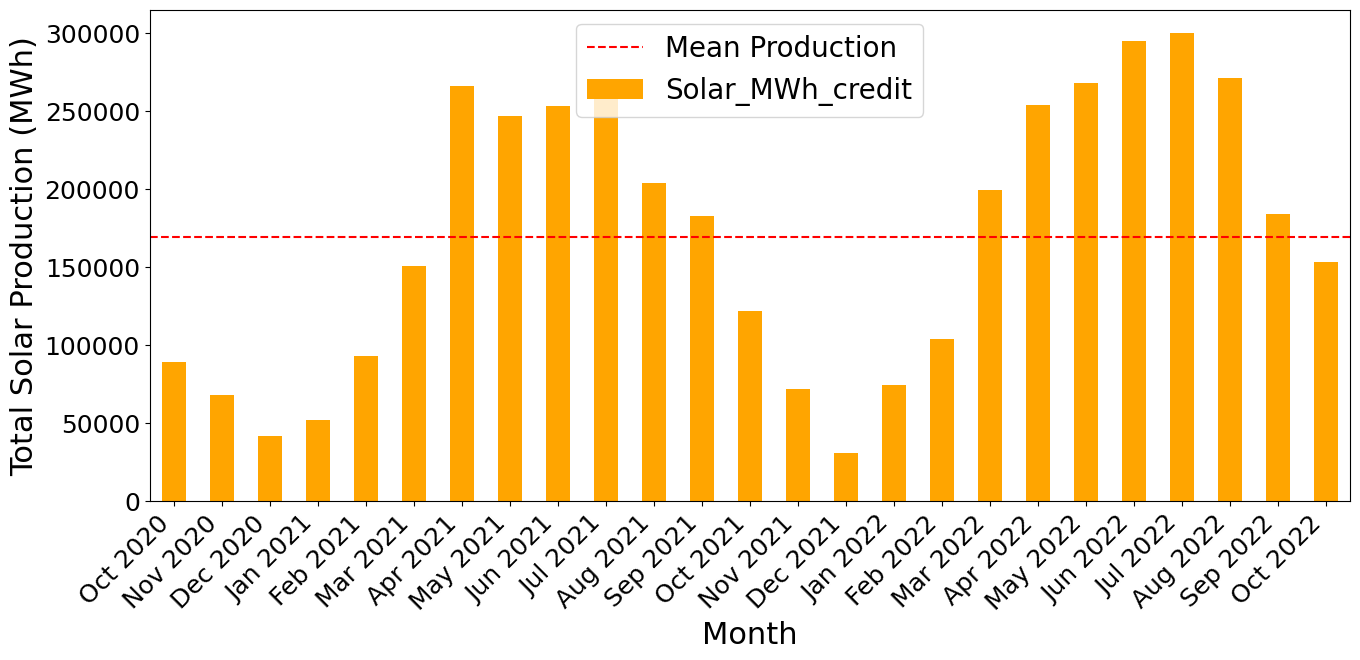

In [9]:
# Load dataset
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])

# Drop duplicates of valid_datetime
train_set.sort_values(["valid_datetime", "ref_datetime"], inplace=True)
train_set = train_set.drop_duplicates(subset="valid_datetime", keep="last")

# Set datetime index
train_set.set_index("valid_datetime", inplace=True)

# Extract year-month as Period
train_set["year_month"] = train_set.index.to_period("M")

# Exclude 09/20 and 11/22
excluded_months = [pd.Period("2020-09"), pd.Period("2022-11")]
train_filtered = train_set[~train_set["year_month"].isin(excluded_months)]

# Resample to monthly wind energy production sum
monthly_solar_sum = train_filtered["Solar_MWh_credit"].resample("M").sum()

# Calculate mean
mean_solar_production = monthly_solar_sum.mean()

# Update font sizes
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 20
})

# Plot
plt.figure(figsize=(14, 7))
ax = monthly_solar_sum.plot(kind='bar', color='orange')

# Use month names on x-axis
months = monthly_solar_sum.index.strftime("%b %Y")
ax.set_xticklabels(months, rotation=45, ha="right")

# Add mean line
plt.axhline(y=mean_solar_production, color='red', linestyle='--', label='Mean Production')

# Labels and title
plt.xlabel("Month")
plt.ylabel("Total Solar Production (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\tilde\AppData\Local\Temp\ipykernel_2872\3000243650.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  train_set["year_month"] = train_set.index.to_period("M")


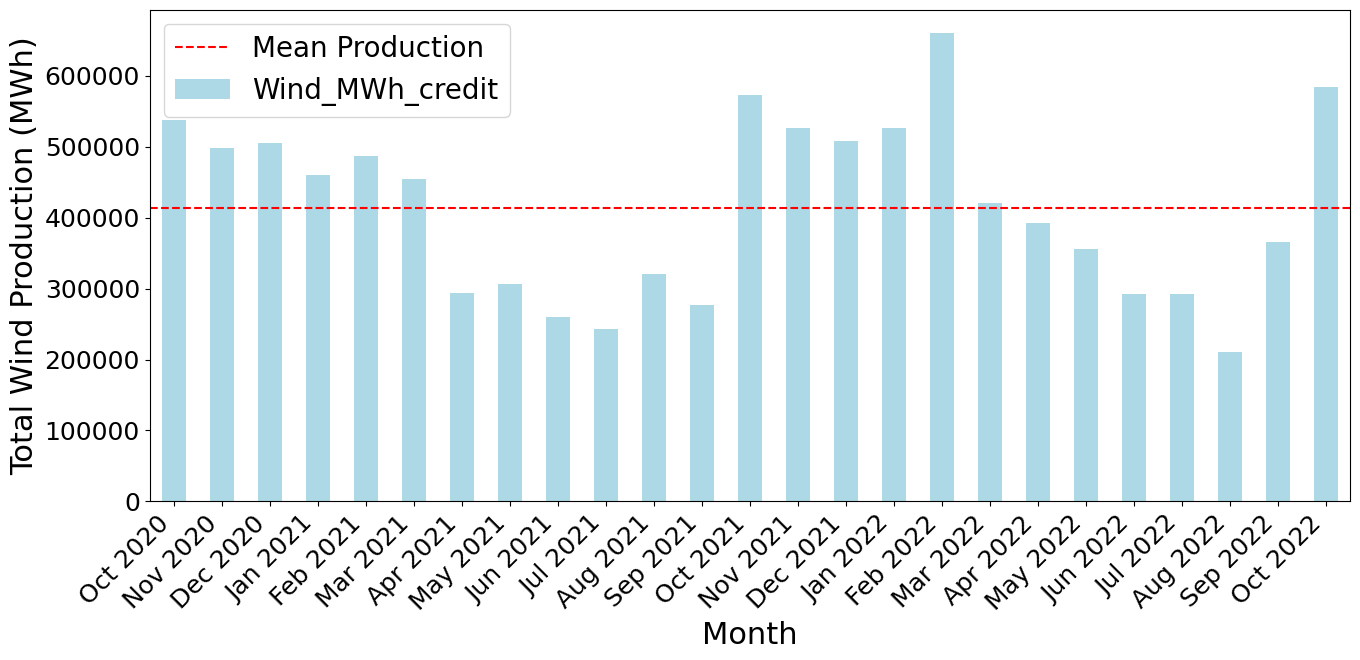

In [10]:
# Load dataset
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])

# Drop duplicates of valid_datetime
train_set.sort_values(["valid_datetime", "ref_datetime"], inplace=True)
train_set = train_set.drop_duplicates(subset="valid_datetime", keep="last")

# Set datetime index
train_set.set_index("valid_datetime", inplace=True)

# Extract year-month as Period
train_set["year_month"] = train_set.index.to_period("M")

# Exclude 09/20 and 11/22
excluded_months = [pd.Period("2020-09"), pd.Period("2022-11")]
train_filtered = train_set[~train_set["year_month"].isin(excluded_months)]

# Resample to monthly wind energy production sum
monthly_wind_sum = train_filtered["Wind_MWh_credit"].resample("M").sum()

# Calculate mean
mean_wind_production = monthly_wind_sum.mean()


# Plot
plt.figure(figsize=(14, 7))
ax = monthly_wind_sum.plot(kind='bar', color='lightblue')

# Use month names on x-axis
months = monthly_wind_sum.index.strftime("%b %Y")
ax.set_xticklabels(months, rotation=45, ha="right")

# Add mean line
plt.axhline(y=mean_wind_production, color='red', linestyle='--', label='Mean Production')

# Labels and title
plt.xlabel("Month")
plt.ylabel("Total Wind Production (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

Based on the plots we create binary variables if a specific month typically has high generation or not for both energy sources. We also create features of daylight, hour of day, day of week, month, and cyclical encoding.

In [11]:
# Load datasets
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])
test_set = pd.read_csv("test_set.csv", parse_dates=["valid_datetime"])

# Function to add high-production flags
def add_high_production_flags(df):
    df["month"] = df["valid_datetime"].dt.month
    df["is_high_solar_month"] = df["month"].between(4, 9).astype(int)  # April to September
    df["is_high_wind_month"] = df["month"].isin([10, 11, 12, 1, 2, 3]).astype(int)
    return df

# Update both datasets
train_set = add_high_production_flags(train_set)
test_set = add_high_production_flags(test_set)

# Save to CSV files
train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

In [12]:
# Load datasets
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])
test_set = pd.read_csv("test_set.csv", parse_dates=["valid_datetime"])

# Define sunrise and sunset times for each month (East England)
sun_times = {
    1:  (time(7, 56), time(16, 23)),
    2:  (time(7, 11), time(17, 17)),
    3:  (time(6, 11), time(18, 6)),
    4:  (time(6, 2),  time(19, 58)),
    5:  (time(5, 5),  time(20, 47)),
    6:  (time(4, 40), time(21, 21)),
    7:  (time(4, 59), time(21, 13)),
    8:  (time(5, 44), time(20, 25)),
    9:  (time(6, 34), time(19, 16)),
    10: (time(7, 23), time(18, 9)),
    11: (time(7, 17), time(16, 13)),
    12: (time(7, 57), time(15, 53)),
}

# Define a feature for daylight

def is_daylight(row):
    month = row['valid_datetime'].month
    current_time = row['valid_datetime'].time()
    sunrise, sunset = sun_times[month]
    return int(sunrise <= current_time <= sunset)

# Define additional features

for df in [train_set, test_set]:
    df["month"] = df["valid_datetime"].dt.month
    df["Day_of_week"] = df["valid_datetime"].dt.dayofweek  # 0=Monday, 6=Sunday
    df["Hour_of_day"] = df["valid_datetime"].dt.hour
    df["is_daylight"] = df.apply(is_daylight, axis=1)
    df["Hour_sin"] = np.sin(2 * np.pi * df["Hour_of_day"] / 24)
    df["Hour_cos"] = np.cos(2 * np.pi * df["Hour_of_day"] / 24)
    df["Day_sin"] = np.sin(2 * np.pi * df["Day_of_week"] / 7)
    df["Day_cos"] = np.cos(2 * np.pi * df["Day_of_week"] / 7)
    df["Month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df['annual_seasonality'] = np.sin(2 * np.pi * df['valid_datetime'].dt.dayofyear / 365)

train_set["solar_generated"] = (train_set["Solar_MWh_credit"] > 0).astype(int)
accuracy = (train_set["is_daylight"] == train_set["solar_generated"]).mean()
print(f" is_daylight feature matches solar production in {accuracy:.2%} of rows")

# Save to CSV files
train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

 is_daylight feature matches solar production in 93.65% of rows


We create Pearson correlation matrices to spot correlation between different features for both solar and wind features.

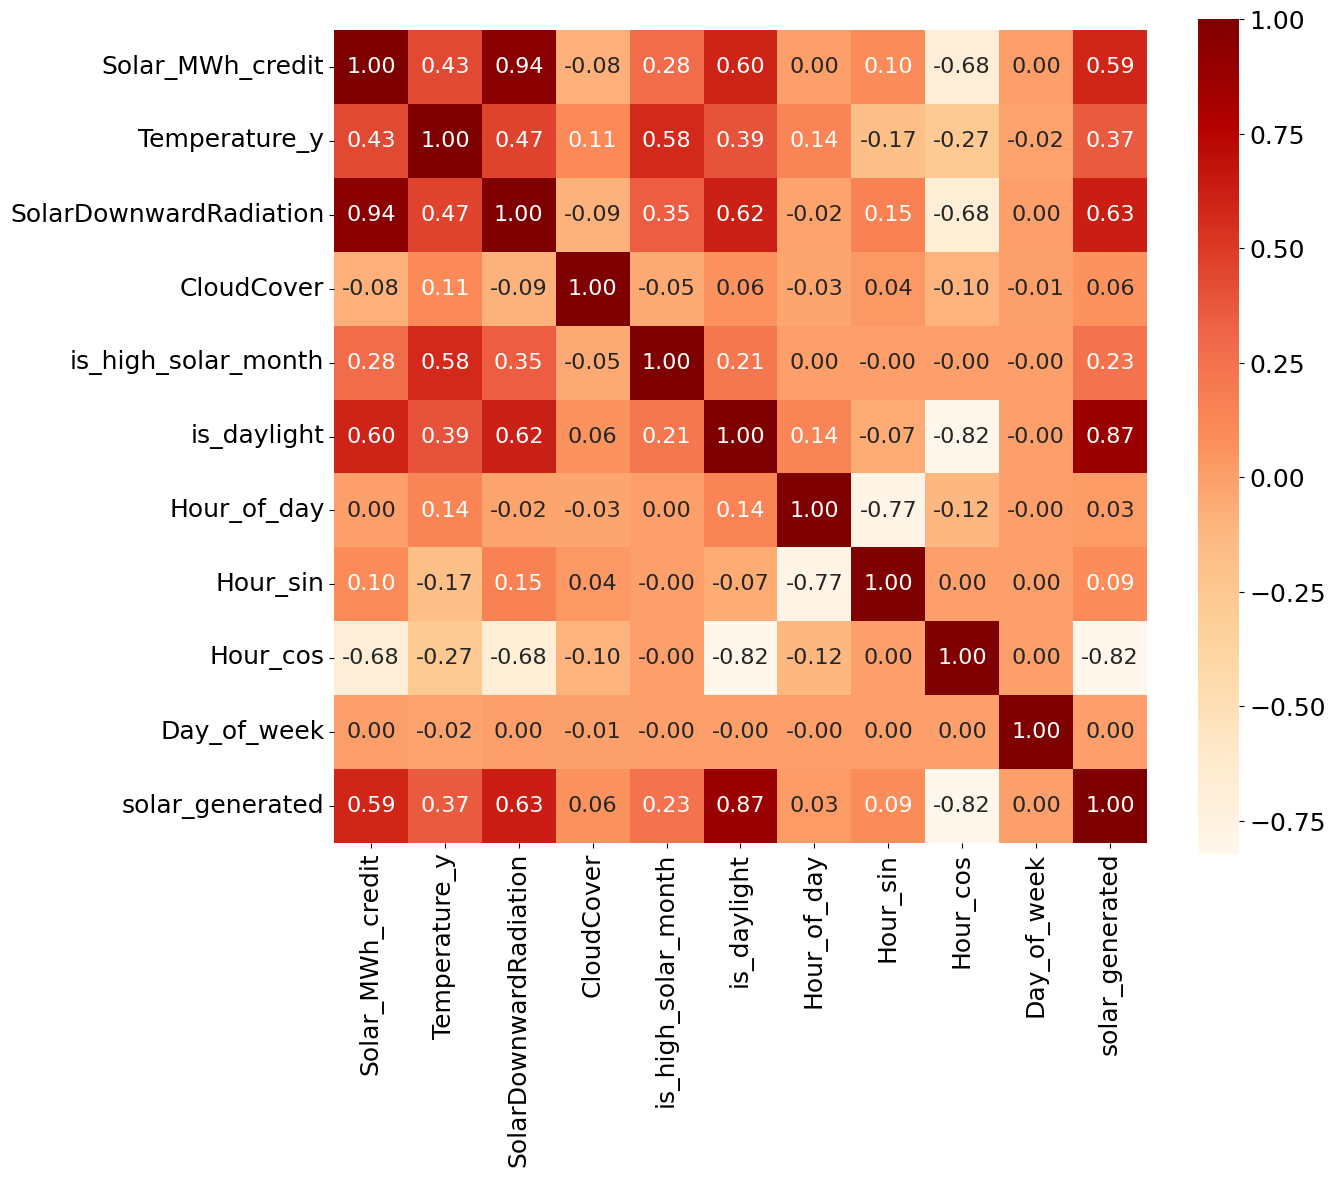

In [13]:
# Load training set
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])

# Keep only numeric columns
numeric_data = train_set.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Features to include in correlation matrix
cols = ["Solar_MWh_credit", "Temperature_y", "SolarDownwardRadiation", "CloudCover", "is_high_solar_month", "is_daylight", "Hour_of_day", "Hour_sin", "Hour_cos", "Day_of_week", "solar_generated"]
sub_corr = correlation_matrix.loc[cols, cols]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(sub_corr, annot=True, fmt=".2f", cmap="OrRd", square=True, annot_kws={'size': 16} )
plt.tight_layout()
plt.show()


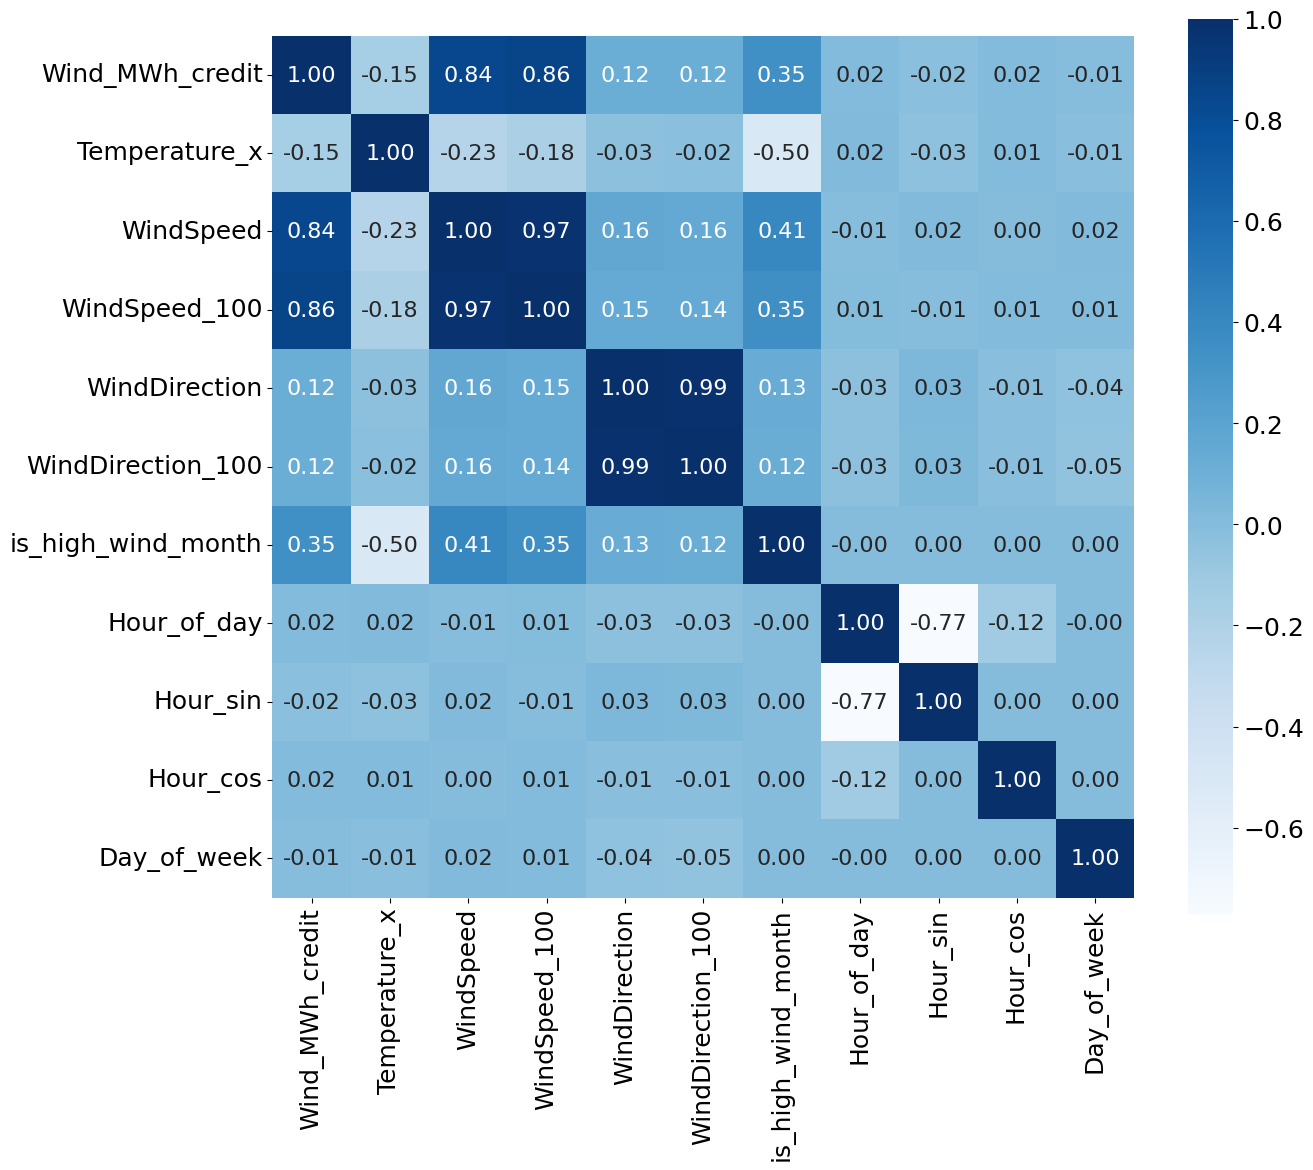

In [14]:
# Load your training set
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])

# Keep only numeric columns
numeric_data = train_set.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Features to include in correlation matrix
cols = ["Wind_MWh_credit", "Temperature_x", "WindSpeed","WindSpeed_100", "WindDirection", "WindDirection_100", "is_high_wind_month", "Hour_of_day", "Hour_sin", "Hour_cos", "Day_of_week"]
sub_corr = correlation_matrix.loc[cols, cols]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(sub_corr, annot=True, fmt=".2f", cmap="Blues", square=True, annot_kws={'size': 16})
plt.tight_layout()
plt.show()

Here we create a simple naive model that simply predicts the exact same value as 24 hours before. For the quantile forecast, it predicts the same value for each quantile. The results of the naive model will be used as a benchmark for the other models. This cell also contains the initial split of the train set into 80/20 train and validation set to use for feature engineering and hyperparameter tuning. Also, a function for pinball score is defined. 

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score
# Load & Prepare Data
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])
test_set = pd.read_csv("test_set.csv", parse_dates=["valid_datetime"])

# Split Train into Train + Validation
train_set = train_set.sort_values("valid_datetime").reset_index(drop=True)
split_idx = int(len(train_set) * 0.8)
train_final = train_set.iloc[:split_idx]
val_set = train_set.iloc[split_idx:]

# Sort validation set by time
val_set_sorted = val_set.sort_values("valid_datetime").reset_index(drop=True)

# Create naive predictions (shifted values)
val_set_sorted["Wind_MWh_Pred"] = val_set_sorted["Wind_MWh_credit"].shift(48)
val_set_sorted["Solar_MWh_Pred"] = val_set_sorted["Solar_MWh_credit"].shift(48)

# Drop rows with NaN predictions
val_set_clean = val_set_sorted.dropna(subset=["Wind_MWh_Pred", "Solar_MWh_Pred"])
val_set_clean = val_set_clean.copy()

# Evaluate Wind
mae_wind = mean_absolute_error(val_set_clean["Wind_MWh_credit"], val_set_clean["Wind_MWh_Pred"])
r2_wind = r2_score(val_set_clean["Wind_MWh_credit"], val_set_clean["Wind_MWh_Pred"])

# Evaluate Solar
mae_solar = mean_absolute_error(val_set_clean["Solar_MWh_credit"], val_set_clean["Solar_MWh_Pred"])
r2_solar = r2_score(val_set_clean["Solar_MWh_credit"], val_set_clean["Solar_MWh_Pred"])

# Print results for wind and solar
print("Naive Model - Solar")
print("MAE:", mae_solar)
print("R²:", r2_solar)

print("Naive Model - Wind")
print("MAE:", mae_wind)
print("R²:", r2_wind)

# Define a combined observations and predicitions
y_total     = val_set_clean["Solar_MWh_credit"] + val_set_clean["Wind_MWh_credit"]
pred_total  = val_set_clean["Solar_MWh_Pred"] + val_set_clean["Wind_MWh_Pred"]

# Print combined results
print("Naive Model - Combined Forecast")
print("Total MAE:",  mean_absolute_error(y_total, pred_total))
print("Total R²:",  r2_score(y_total, pred_total))

# Define Pinball Loss function
def pinball_loss(y, q, alpha):
    return np.where(y >= q, alpha * (y - q), (1 - alpha) * (q - y))

# Define a function to calculate the average Pinball loss over a range of quantiles
def pinball_score(y_true, y_pred, quantiles):
    scores = []
    for q in quantiles:
        alpha = q / 100  # Convert quantile to alpha
        scores.append(np.mean(pinball_loss(y_true, y_pred, alpha)))  # Average Pinball loss
    return np.mean(scores)

# Quantiles to evaluate
quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Pinball loss for Wind
pinball_loss_wind = pinball_score(val_set_clean["Wind_MWh_credit"], val_set_clean["Wind_MWh_Pred"], quantiles)

# Pinball loss for Solar
pinball_loss_solar = pinball_score(val_set_clean["Solar_MWh_credit"], val_set_clean["Solar_MWh_Pred"], quantiles)

# Combine Wind and Solar predictions
val_set_clean.loc[:, "Combined_MWh_Pred"] = val_set_clean["Wind_MWh_Pred"] + val_set_clean["Solar_MWh_Pred"]
val_set_clean.loc[:, "Combined_MWh_credit"] = val_set_clean["Wind_MWh_credit"] + val_set_clean["Solar_MWh_credit"]

# Pinball loss for Combined Generation
pinball_loss_combined = pinball_score(val_set_clean["Combined_MWh_credit"], val_set_clean["Combined_MWh_Pred"], quantiles)

# Print Results
print(f"Naive Model - Average Pinball loss (Solar): {pinball_loss_solar:.4f}")
print(f"Naive Model - Average Pinball loss (Wind): {pinball_loss_wind:.4f}")
print(f"Naive Model - Average Pinball loss (Combined): {pinball_loss_combined:.4f}")

Naive Model - Solar
MAE: 112.52216072938495
R²: 0.24742704107962576
Naive Model - Wind
MAE: 65.43931786593448
R²: 0.7707069223252085
Naive Model - Combined Forecast
Total MAE: 147.08472529439857
Total R²: 0.4408468991333624
Naive Model - Average Pinball loss (Solar): 56.2611
Naive Model - Average Pinball loss (Wind): 32.7197
Naive Model - Average Pinball loss (Combined): 73.5424


This is the point forecast of Random Forest Regression. Here we also include lags into the train set, and establish a feasible feature set through trial and error. We tune the hyperparameters using grid search and cross-validation. We also investigate the feature importance of the prediction.

In [18]:
# Retrieving Model & Grid Search Tool
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load & Prepare Data
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])
test_set = pd.read_csv("test_set.csv", parse_dates=["valid_datetime"])

# Create amount of lags
LAGS = list(range(48,60))

# Use them on the training set
lagged = {
    **{f"Solar_MWh_lag{lag}": train_set.groupby("ref_datetime")["Solar_MWh_credit"].shift(lag)
       for lag in LAGS},
    **{f"Wind_MWh_lag{lag}":  train_set.groupby("ref_datetime")["Wind_MWh_credit"].shift(lag)
       for lag in LAGS},
}
# Create dataframe including the lags
lags_df = pd.DataFrame(lagged, index=train_set.index)
train_set = pd.concat([train_set, lags_df], axis=1)

# Drop rows with missing lags
train_set = train_set.iloc[max(LAGS):].reset_index(drop=True)

# Split into training and validation
split_idx  = int(len(train_set) * 0.8)
train_final = train_set.iloc[:split_idx].reset_index(drop=True)
val_set     = train_set.iloc[split_idx:].reset_index(drop=True)

# Now drop the initial rows that contain NaNs from the largest lag
train_set = train_set.iloc[max(LAGS):].reset_index(drop=True)

# Sort values according to valid_datetime
train_set = train_set.sort_values("valid_datetime").reset_index(drop=True)

# Feature Sets
solar_features = [
    "SolarDownwardRadiation",
    "CloudCover",
    "is_high_solar_month",
    "Hour_of_day",
    "Temperature_y",
    "Hour_sin",
    "Hour_cos",
    "Day_sin",
    "Day_cos",
    "is_daylight",
    "SolarDownwardRadiation_t24",
    "CloudCover_t24",
    "Temperature_y_t24",
    *[f"Solar_MWh_lag{lag}" for lag in LAGS]
]
wind_features = [
    "WindSpeed",
    "WindSpeed_100",
    'WindDirection',
    "WindDirection_sin",
    "WindDirection_cos",
    "WindDirection_100_sin",
    "WindDirection_100_cos",
    "Temperature_x",
    "is_high_wind_month",
    "Hour_of_day",
    "Hour_sin",
    "Hour_cos",
    "Day_sin",
    "Day_cos",
    "WindSpeed_t24",
    "WindDirection_t24",
    "WindDirection_sin_t24",
    "WindDirection_cos_t24",
    "WindDirection_100_t24",
    "WindDirection_100_sin_t24",
    *[f"Wind_MWh_lag{lag}" for lag in LAGS]]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Solar model tuning
X_train_solar = train_final[solar_features]
y_train_solar = train_final["Solar_MWh_credit"]

# Hyper parameters for the model that is used in grid search (only the best parameter tested is left to save computation time)
solar_param_grid = {
    "n_estimators": [300],
    "max_depth": [10],
    "min_samples_leaf": [4]
}

# Perform grid search
solar_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42,n_jobs=-1), # n_jobs=-1 -> using all cored in CPU -> faster computation time
    param_grid=solar_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model and save best hyperparameter
solar_grid.fit(X_train_solar, y_train_solar)
best_solar_rfr = solar_grid.best_estimator_
print("Best Solar Parameters:", solar_grid.best_params_)

# Validation performance
X_val_solar = val_set[solar_features]
y_val_solar = val_set["Solar_MWh_credit"]
val_pred_solar_rfr = best_solar_rfr.predict(X_val_solar)

# Print
print("Solar Validation MAE:", mean_absolute_error(y_val_solar, val_pred_solar_rfr))
print("Solar Validation R²:", r2_score(y_val_solar, val_pred_solar_rfr))

# Solar feature importance
solar_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_solar.columns,
        'Importance': best_solar_rfr.feature_importances_
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
print("\nSolar feature importances:")
print(solar_imp_df.head(5))

# Wind Model Tuning
X_train_wind = train_final[wind_features]
y_train_wind = train_final["Wind_MWh_credit"]

# Hyper parameters for the model that is used in grid search
wind_param_grid = {
    "n_estimators": [300],
    "max_depth": [10],
    "min_samples_leaf": [4]
}
# Perform grid search
wind_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42,n_jobs=-1),
    param_grid=wind_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model and save best hyperparameter
wind_grid.fit(X_train_wind, y_train_wind)
best_wind_rfr = wind_grid.best_estimator_
print("Best Wind Params:", wind_grid.best_params_)

# Validation performance
X_val_wind = val_set[wind_features]
y_val_wind = val_set["Wind_MWh_credit"]
val_pred_wind_rfr = best_wind_rfr.predict(X_val_wind)

# Print
print("Wind Validation MAE:", mean_absolute_error(y_val_wind, val_pred_wind_rfr))
print("Wind Validation R²:", r2_score(y_val_wind, val_pred_wind_rfr))

# Feature importance
wind_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_wind.columns,
        'Importance': best_wind_rfr.feature_importances_
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
print("\nWind feature importances:")
print(wind_imp_df.head(5))

# Combined predictions and outputs
y_total = y_val_solar + y_val_wind
pred_total = val_pred_solar_rfr + val_pred_wind_rfr

# Combined validation
print("Combined Validation MAE:", mean_absolute_error(y_total, pred_total))
print("Combined Validation R²:", r2_score(y_total, pred_total))

Best Solar Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300}
Solar Validation MAE: 23.78086298654577
Solar Validation R²: 0.9434931943911915

Solar feature importances:
                  Feature  Importance
0  SolarDownwardRadiation    0.949846
1                Hour_cos    0.021054
2              CloudCover    0.005729
3           Temperature_y    0.004408
4         Solar_MWh_lag48    0.003429
Best Wind Params: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300}
Wind Validation MAE: 62.544610082202
Wind Validation R²: 0.8267970678861956

Wind feature importances:
                 Feature  Importance
0          WindSpeed_100    0.962039
1          Temperature_x    0.005751
2              WindSpeed    0.004763
3  WindDirection_100_cos    0.002194
4                Day_sin    0.002173
Combined Validation MAE: 72.79881516980628
Combined Validation R²: 0.8635222692052196


This is the quantile forecast of Random Forest Regression.

In [19]:
QUANTILES = list(range(10, 100, 10))

# Pinball Loss
def pinball_loss(y_true, y_pred, alpha):
    loss = (y_true - y_pred) * alpha * (y_true >= y_pred) + (y_pred - y_true) * (1 - alpha) * (y_true < y_pred)
    return np.mean(loss)

def average_pinball_loss(y_true, quantile_preds):
    losses = []
    for quantile in QUANTILES:
        losses.append(pinball_loss(y_true, quantile_preds[f'q{quantile}'], quantile/100))
    return np.mean(losses)

print("\nSolar Forecast (Random Forest)")

# Solar Forecast
solar_rfr = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=4,
    n_jobs=-1,            
    random_state=42
)
# Train model
solar_rfr.fit(X_train_solar, y_train_solar)

# Parallelize the per-tree predictions
solar_tree_preds = Parallel(n_jobs=-1)(
    delayed(tree.predict)(X_val_solar.values)
    for tree in solar_rfr.estimators_
)
# Stack tree-predictions into array
solar_tree_preds = np.stack(solar_tree_preds, axis=0)

# Compute quantiles
solar_quantile_rfr = {
    f"q{q}": np.percentile(solar_tree_preds, q, axis=0)
    for q in QUANTILES
}

# Add true solar output and each quantile prediction column
solar_modelling_table = val_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_val_solar
for quantile in QUANTILES:
    solar_modelling_table[f'q{quantile}'] = solar_quantile_rfr[f'q{quantile}']

print(f"Average Pinball Loss (Solar): {average_pinball_loss(solar_modelling_table['solar_generation_MWh'], solar_modelling_table):.4f}")

print("\nWind Forecast (Random Forest)")

# Wind Forecast
wind_rfr = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=4,
    n_jobs=-1,  
    random_state=42
)
# Train model
wind_rfr.fit(X_train_wind, y_train_wind)

# Parallelize the per-tree predictions
wind_tree_preds = Parallel(n_jobs=-1)(
    delayed(tree.predict)(X_val_wind.values)
    for tree in wind_rfr.estimators_
)
# Stack tree-predictions into array
wind_tree_preds = np.stack(wind_tree_preds, axis=0)

# Compute quantiles
wind_quantile_rfr = {
    f"q{q}": np.percentile(wind_tree_preds, q, axis=0)
    for q in QUANTILES
}

# Add true solar output and each quantile prediction column
wind_modelling_table = val_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_val_wind
for quantile in QUANTILES:
    wind_modelling_table[f'q{quantile}'] = wind_quantile_rfr[f'q{quantile}']

print(f"Average Pinball Loss (Wind): {average_pinball_loss(wind_modelling_table['wind_generation_MWh'], wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

# Combine solar and wind generation 
combined_modelling_table = val_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] + wind_modelling_table["wind_generation_MWh"]
)

# Compute quantiles
for quantile in QUANTILES:
    combined_modelling_table[f'q{quantile}'] = (
        solar_modelling_table[f'q{quantile}'] + wind_modelling_table[f'q{quantile}']
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")



Solar Forecast (Random Forest)
Average Pinball Loss (Solar): 10.2932

Wind Forecast (Random Forest)
Average Pinball Loss (Wind): 26.5759

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 30.5650


This is the point forecast of CatBoost.

In [21]:
from catboost import CatBoostRegressor

# Solar Model Tuning
X_train_solar = train_final[solar_features]
y_train_solar = train_final["Solar_MWh_credit"]

# Hyper parameters for the grid search
solar_param_grid = {
    "iterations": [200, 300],
    "depth": [4, 8],
    "learning_rate": [0.05, 0.1]
}

# Perform grid search
solar_grid = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function="MAE",
        verbose=0,
        random_state=42),
    param_grid=solar_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model and save best hyperparameter
solar_grid.fit(X_train_solar, y_train_solar)
best_solar_ctb = solar_grid.best_estimator_
print("Best Solar Parameters:", solar_grid.best_params_)

# Validation performance
X_val_solar = val_set[solar_features]
y_val_solar = val_set["Solar_MWh_credit"]
val_pred_solar_ctb = best_solar_ctb.predict(X_val_solar)
print("Solar Validation MAE:", mean_absolute_error(y_val_solar, val_pred_solar_ctb))
print("Solar Validation R²:", r2_score(y_val_solar, val_pred_solar_ctb))

# Solar feature importance
solar_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_solar.columns,
        'Importance': best_solar_ctb.feature_importances_/100
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
print("\nSolar feature importances:")
print(solar_imp_df.head(5))

# Wind Model Tuning
X_train_wind = train_final[wind_features]
y_train_wind = train_final["Wind_MWh_credit"]

# Hyper parameters for the grid search
wind_param_grid = {
    "iterations": [200, 300],
    "depth": [4, 8],
    "learning_rate": [0.05, 0.1]
}
# Perform grid search
wind_grid = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function="MAE",
        verbose=0,
        random_state=42),
    param_grid=wind_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model and save best hyperparameter
wind_grid.fit(X_train_wind, y_train_wind)
best_wind_ctb = wind_grid.best_estimator_
print("Best Wind Params:", wind_grid.best_params_)

# Validation performance
X_val_wind = val_set[wind_features]
y_val_wind = val_set["Wind_MWh_credit"]
val_pred_wind_ctb = best_wind_ctb.predict(X_val_wind)
print("Wind Validation MAE:", mean_absolute_error(y_val_wind, val_pred_wind_ctb))
print("Wind Validation R²:", r2_score(y_val_wind, val_pred_wind_ctb))

# Wind feature importance
wind_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_wind.columns,
        'Importance': best_wind_ctb.feature_importances_/100
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
# Feature importance value between 0-1
print("\nWind feature importances:")
print(wind_imp_df.head(5))

# Combined predictions and outputs
y_total = y_val_solar + y_val_wind
pred_total = val_pred_solar_ctb + val_pred_wind_ctb

# Combined validation
print("Combined Validation MAE:", mean_absolute_error(y_total, pred_total))
print("Combined Validation R²:", r2_score(y_total, pred_total))

C:\Users\tilde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Solar Parameters: {'depth': 4, 'iterations': 300, 'learning_rate': 0.1}
Solar Validation MAE: 24.380742732234985
Solar Validation R²: 0.9398294637854465

Solar feature importances:
                  Feature  Importance
0  SolarDownwardRadiation    0.851848
1                Hour_cos    0.061280
2              CloudCover    0.022448
3             is_daylight    0.019389
4                Hour_sin    0.012432
Best Wind Params: {'depth': 4, 'iterations': 200, 'learning_rate': 0.05}
Wind Validation MAE: 56.904765085096905
Wind Validation R²: 0.8346163199365846

Wind feature importances:
             Feature  Importance
0      WindSpeed_100    0.966873
1      Temperature_x    0.006404
2          WindSpeed    0.005774
3  WindDirection_cos    0.004526
4      WindDirection    0.002763
Combined Validation MAE: 68.29835723694086
Combined Validation R²: 0.8676758846515187


This is the quantile forecast of CatBoost.

In [22]:
#Pinball Loss
QUANTILES = list(range(10, 100, 10))

def average_pinball_loss(y_true, quantile_preds):
    return np.mean([
        pinball_loss(y_true, quantile_preds[f"q{q}"], q / 100) for q in QUANTILES
    ])

# Solar Forecast (CatBoost)
print("\nSolar Forecast (CatBoost Quantile)")

# Predicted and actual value for training and validation for solar
X_train_solar = train_final[solar_features]         # Prediction for training
y_train_solar = train_final["Solar_MWh_credit"]     # Actual solar generation for training
X_val_solar = val_set[solar_features]               # Prediction for validation
y_val_solar = val_set["Solar_MWh_credit"]           # Actual solar generation for validation

# Introduce variable
solar_quantile_ctb = {}
solar_models_ctb = {}

# Perform quantile forecast
for q in QUANTILES:
    solar_ctb = CatBoostRegressor(
        loss_function='Quantile:alpha={}'.format(q / 100),
        iterations=300,
        depth=4,
        learning_rate=0.1,
        verbose=0,
        random_state=42
    )
    # Train model
    solar_ctb.fit(X_train_solar, y_train_solar)
    solar_quantile_ctb[f"q{q}"] = solar_ctb.predict(X_val_solar)
    solar_models_ctb[q] = solar_ctb

# Add actual solar value and appending the quantile prediction 
solar_modelling_table = val_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_val_solar.values
for q in QUANTILES:
    solar_modelling_table[f"q{q}"] = solar_quantile_ctb[f"q{q}"]

print(f"Average Pinball Loss (Solar): {average_pinball_loss(y_val_solar, solar_modelling_table):.4f}")

# Wind Forecast (CatBoost)
print("\nWind Forecast (CatBoost Quantile)")

X_train_wind = train_final[wind_features]
y_train_wind = train_final["Wind_MWh_credit"]
X_val_wind = val_set[wind_features]
y_val_wind = val_set["Wind_MWh_credit"]

# Introduce variables
wind_quantile_ctb = {}
wind_models_ctb = {}

# Perform quantile forecast
for q in QUANTILES:
    wind_ctb = CatBoostRegressor(
        loss_function='Quantile:alpha={}'.format(q / 100),
        iterations=200,
        depth=4,
        learning_rate=0.05,
        verbose=0,
        random_state=42
    )
    # Train model
    wind_ctb.fit(X_train_wind, y_train_wind)
    wind_quantile_ctb[f"q{q}"] = wind_ctb.predict(X_val_wind)
    wind_models_ctb[q] = wind_ctb

# Add actual wind value and appending the quantile prediction 
wind_modelling_table = val_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_val_wind.values
for q in QUANTILES:
    wind_modelling_table[f"q{q}"] = wind_quantile_ctb[f"q{q}"]

print(f"Average Pinball Loss (Wind): {average_pinball_loss(y_val_wind, wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

# Combine solar and wind
combined_modelling_table = val_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] +
    wind_modelling_table["wind_generation_MWh"]
)

# Calculate quantile prediction
for q in QUANTILES:
    combined_modelling_table[f"q{q}"] = (
        solar_modelling_table[f"q{q}"] + wind_modelling_table[f"q{q}"]
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")


Solar Forecast (CatBoost Quantile)
Average Pinball Loss (Solar): 9.5856

Wind Forecast (CatBoost Quantile)
Average Pinball Loss (Wind): 22.4965

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 27.4739


This is the point forecast of LightGBM.

In [24]:
import lightgbm as lgb

# Solar Model Tuning
X_train_solar = train_final[solar_features]
y_train_solar = train_final["Solar_MWh_credit"]

# Hyper parameters for the grid search
solar_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.9],
    "colsample_bytree": [0.6, 0.9]
}
# Grid search
solar_grid = GridSearchCV(
    estimator = lgb.LGBMRegressor(
        objective="quantile",
        alpha=q / 100,
        random_state=42,
        verbose=0
    ),
    param_grid=wind_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model
solar_grid.fit(X_train_solar, y_train_solar)
best_solar_lgbm = solar_grid.best_estimator_
print("Best Solar Parameters:", solar_grid.best_params_)

# Validation performance
X_val_solar = val_set[solar_features]
y_val_solar = val_set["Solar_MWh_credit"]
val_pred_solar_lgbm = best_solar_lgbm.predict(X_val_solar)
print("Solar Validation MAE:", mean_absolute_error(y_val_solar, val_pred_solar_lgbm))
print("Solar Validation R²:", r2_score(y_val_solar, val_pred_solar_lgbm))

# Solar feature importance
solar_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_solar.columns,
        'Importance': best_solar_lgbm.feature_importances_
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
print("\nSolar feature importances:")
imp = solar_imp_df['Importance']
solar_imp_df['Importance'] = imp / imp.sum()
print(solar_imp_df[['Feature','Importance']].head(5))

# Wind model tuning
X_train_wind = train_final[wind_features]
y_train_wind = train_final["Wind_MWh_credit"]

# Hyper parameters for the grid search
wind_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.9],
    "colsample_bytree": [0.6, 0.9]
}

wind_grid = GridSearchCV(
    estimator = lgb.LGBMRegressor(
        objective="quantile",
        alpha=q / 100,
        random_state=42,
        verbose=0
    ),
    param_grid=wind_param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1
)
# Train model
wind_grid.fit(X_train_wind, y_train_wind)
best_wind_lgbm = wind_grid.best_estimator_
print("Best Wind Params:", wind_grid.best_params_)

# Validation performance
X_val_wind = val_set[wind_features]
y_val_wind = val_set["Wind_MWh_credit"]
val_pred_wind_lgbm = best_wind_lgbm.predict(X_val_wind)
print("Wind Validation MAE:", mean_absolute_error(y_val_wind, val_pred_wind_lgbm))
print("Wind Validation R²:", r2_score(y_val_wind, val_pred_wind_lgbm))

# Wind feature importance
wind_imp_df = (
    pd.DataFrame({
        'Feature':    X_train_wind.columns,
        'Importance': best_wind_lgbm.feature_importances_
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
print("\nWind feature importances:")
imp = wind_imp_df['Importance']
wind_imp_df['Importance'] = imp / imp.sum()
print(wind_imp_df[['Feature','Importance']].head(5))

# Combined predictions and outputs
y_total = y_val_solar + y_val_wind
pred_total = val_pred_solar_lgbm + val_pred_wind_lgbm

# Combined validation
print("Combined Validation MAE:", mean_absolute_error(y_total, pred_total))
print("Combined Validation R²:", r2_score(y_total, pred_total))

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
Best Solar Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
Solar Validation MAE: 41.11120953222073
Solar Validation R²: 0.864813209459984

Solar feature importances:
                  Feature  Importance
0  SolarDownwardRadiation    0.200000
1              CloudCover    0.131667
2           Temperature_y    0.129000
3         Solar_MWh_lag48    0.095333
4             Hour_of_day    0.079333
Best Wind Params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.6}
Wind Validation MAE: 96.20886965708284
Wind Validation R²: 0.622903642618567

Wind feature importances:
          Feature  Importance
0   Temperature_x    0.099333
1   WindSpee

This is the quantile forecast of LightGBM.

In [25]:
# Setup LightGBM

def average_pinball_loss(y_true, quantile_preds):
    return np.mean([
        pinball_loss(y_true, quantile_preds[f"q{q}"], q / 100) for q in QUANTILES
    ])

# Solar Forecast
X_train_solar = train_final[solar_features].copy()
y_train_solar = train_final["Solar_MWh_credit"]
X_val_solar = val_set[solar_features].copy()
y_val_solar = val_set["Solar_MWh_credit"]

# Introduce variables 
solar_quantile_lgbm = {}
solar_models_lgbm= {}

# Optimize pinball loss for each quantile
for q in QUANTILES:
    solar_lgbm = lgb.LGBMRegressor(
        objective="quantile",
        alpha=q / 100,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        verbose=0
    )
    # Train model
    solar_lgbm.fit(X_train_solar, y_train_solar)
    solar_quantile_lgbm[f"q{q}"] = solar_lgbm.predict(X_val_solar)
    solar_models_lgbm[q] = solar_lgbm

# Add actual solar value and appending the quantile prediction 
solar_modelling_table = val_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_val_solar.values
for q in QUANTILES:
    solar_modelling_table[f"q{q}"] = solar_quantile_lgbm[f"q{q}"]

# Wind Forecast
X_train_wind = train_final[wind_features].copy()
y_train_wind = train_final["Wind_MWh_credit"]
X_val_wind = val_set[wind_features].copy()
y_val_wind = val_set["Wind_MWh_credit"]

# Introduce variables
wind_quantile_lgbm = {}
wind_models_lgbm= {}
for q in QUANTILES:
    wind_lgbm = lgb.LGBMRegressor(
        objective="quantile",
        alpha=q / 100,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.6,
        random_state=42,
        verbose=0
    )
    # Train model
    wind_lgbm.fit(X_train_wind, y_train_wind)
    wind_quantile_lgbm[f"q{q}"] = wind_lgbm.predict(X_val_wind)
    wind_models_lgbm[q] = wind_lgbm

# Add actual wind value and appending the quantile prediction 
wind_modelling_table = val_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_val_wind.values
for q in QUANTILES:
    wind_modelling_table[f"q{q}"] = wind_quantile_lgbm[f"q{q}"]

# Combined Forecast
combined_modelling_table = val_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] + wind_modelling_table["wind_generation_MWh"]
)
# Combine solar and wind
for q in QUANTILES:
    combined_modelling_table[f"q{q}"] = (
        solar_modelling_table[f"q{q}"] + wind_modelling_table[f"q{q}"]
    )

# Print results
print(f"Average Pinball Loss (Solar): {average_pinball_loss(solar_modelling_table['solar_generation_MWh'], solar_modelling_table):.4f}")
print(f"Average Pinball Loss (Wind): {average_pinball_loss(wind_modelling_table['wind_generation_MWh'], wind_modelling_table):.4f}")
print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")

Average Pinball Loss (Solar): 9.4465
Average Pinball Loss (Wind): 23.5559
Average Pinball Loss (Combined): 28.1955


Here we define our point ensemble model using linear regression to train the model to weight the predictions of the three models in accordance with minimizing the error. 

In [26]:
from sklearn.linear_model import LinearRegression

# Solar Point Forecast Stacking
X_meta_point_solar = pd.DataFrame({
    "rf":  val_pred_solar_rfr,
    "cat": val_pred_solar_ctb,
    "lgbm": val_pred_solar_lgbm
})
# True solar outputs
y_meta_point_solar = y_val_solar.values

# Fit linear regressor on the meta-features
stacked_model_point_solar = LinearRegression()
stacked_model_point_solar.fit(X_meta_point_solar, y_meta_point_solar)

# Generate the stacked predictions
stacked_pred_solar_point = stacked_model_point_solar.predict(X_meta_point_solar)

# Evaluate performance
mae_solar = mean_absolute_error(y_meta_point_solar, stacked_pred_solar_point)
r2_solar = r2_score(y_meta_point_solar, stacked_pred_solar_point)

# Print
print(f" Stacked Linear Regression (Solar - Point Forecast):")
print(f" MAE: {mae_solar:.4f}")
print(f" R² : {r2_solar:.4f}")

# Wind point forecast stacking
X_meta_point_wind = pd.DataFrame({
    "rf":  val_pred_wind_rfr,
    "cat": val_pred_wind_ctb,
    "lgbm": val_pred_wind_lgbm
})
# True wind outputs
y_meta_point_wind = y_val_wind.values

# Fit linear regressor on the meta-features
stacked_model_point_wind = LinearRegression()
stacked_model_point_wind.fit(X_meta_point_wind, y_meta_point_wind)
stacked_pred_wind_point = stacked_model_point_wind.predict(X_meta_point_wind)

# Evaluate performance
mae_wind = mean_absolute_error(y_meta_point_wind, stacked_pred_wind_point)
r2_wind = r2_score(y_meta_point_wind, stacked_pred_wind_point)

# Print
print(f"\n Stacked Linear Regression (Wind - Point Forecast):")
print(f" MAE: {mae_wind:.4f}")
print(f" R² : {r2_wind:.4f}")

# Combined predictions and outputs
y_total = y_meta_point_solar + y_meta_point_wind
pred_total = stacked_pred_solar_point + stacked_pred_wind_point

# Evaluate performance
mae_wind = mean_absolute_error(y_total, pred_total)
r2_wind = r2_score(y_total, pred_total)

# Print
print(f"\n Stacked Linear Regression (Combined):")
print(f" MAE: {mae_wind:.4f}")
print(f" R² : {r2_wind:.4f}")

 Stacked Linear Regression (Solar - Point Forecast):
 MAE: 24.4258
 R² : 0.9450

 Stacked Linear Regression (Wind - Point Forecast):
 MAE: 58.4290
 R² : 0.8389

 Stacked Linear Regression (Combined):
 MAE: 68.8029
 R² : 0.8729


Here we define our quantile ensemble model using quantile regression to train the model to weight the predictions of the three quantile forecast models in accordance with minimizing the pinball loss.

In [27]:
from sklearn.linear_model import QuantileRegressor

# Introduce variable
meta_models_solar = {}  
meta_preds_solar = {}    

# Predictions of all models are used as features in the meta-model
for q in QUANTILES:
    X_meta = pd.DataFrame({
        "rf":   solar_quantile_rfr[f"q{q}"],
        "cat":  solar_quantile_ctb[f"q{q}"],
        "lgbm": solar_quantile_lgbm[f"q{q}"]
    })
    # Target
    y_meta = y_val_solar.values 

    # Fit linear regression
    model = QuantileRegressor(quantile=q/100).fit(X_meta, y_meta)
    
    # Save model and predictions
    meta_models_solar[q] = model
    meta_preds_solar[f"q{q}"] = model.predict(X_meta)

In [28]:
# Introduce variable
meta_models_wind = {}
meta_preds_wind = {}

# Predictions of all models are used as features in the meta-model
for q in QUANTILES:
    X_meta = pd.DataFrame({
        "rf":   wind_quantile_rfr[f"q{q}"],
        "cat":  wind_quantile_ctb[f"q{q}"],
        "lgbm": wind_quantile_lgbm[f"q{q}"]
    })
    # Target    
    y_meta = y_val_wind.values

    # Fit quantile regression
    model = QuantileRegressor(quantile=q/100).fit(X_meta, y_meta)

    #  Save model and predictions
    meta_models_wind[q] = model
    meta_preds_wind[f"q{q}"] = model.predict(X_meta)
    

In [29]:
print("\nStacked Model Evaluation")

# Average pinball loss solar
solar_stacked_loss = average_pinball_loss(y_val_solar, meta_preds_solar)
print(f"Average Pinball Loss (Solar - Stacked): {solar_stacked_loss:.4f}")

# Average pinball loss wind
wind_stacked_loss = average_pinball_loss(y_val_wind, meta_preds_wind)
print(f"Average Pinball Loss (Wind - Stacked): {wind_stacked_loss:.4f}")

# Combined targets
y_val_combined = y_val_solar.values + y_val_wind.values

# Combined predictions
meta_preds_combined = {
    f"q{q}": meta_preds_solar[f"q{q}"] + meta_preds_wind[f"q{q}"]
    for q in QUANTILES
}

# Average pinball loss combined
combined_stacked_loss = average_pinball_loss(y_val_combined, meta_preds_combined)
print(f"Average Pinball Loss (Combined - Stacked): {combined_stacked_loss:.4f}")


Stacked Model Evaluation
Average Pinball Loss (Solar - Stacked): 9.1979
Average Pinball Loss (Wind - Stacked): 22.1661
Average Pinball Loss (Combined - Stacked): 26.7050


Here we calculate the pinball loss for each quantile.

In [30]:
print("\nPinball Loss per Quantile Solar\n")

for q in QUANTILES:
    alpha = q / 100
    q_str = f"q{q}"
    # Compute pinball loss for each model’s predictions
    loss_rf   = pinball_loss(y_val_solar, solar_quantile_rfr[q_str], alpha)
    loss_cat  = pinball_loss(y_val_solar, solar_quantile_ctb[q_str], alpha)
    loss_lgbm = pinball_loss(y_val_solar, solar_quantile_lgbm[q_str], alpha)
    loss_stack= pinball_loss(y_val_solar, meta_preds_solar[q_str], alpha)
    # Print for each quantile
    print(f"Quantile q{q:2}:  RF={loss_rf:.4f}  CatBoost={loss_cat:.4f}  LightGBM={loss_lgbm:.4f}  Stacked={loss_stack:.4f}")

print("\nPinball Loss per Quantile Wind\n")

for q in QUANTILES:
    alpha = q / 100
    q_str = f"q{q}"
    # Compute pinball loss for each model’s predictions
    loss_rf   = pinball_loss(y_val_wind, wind_quantile_rfr[q_str], alpha)
    loss_cat  = pinball_loss(y_val_wind, wind_quantile_ctb[q_str], alpha)
    loss_lgbm = pinball_loss(y_val_wind, wind_quantile_lgbm[q_str], alpha)
    loss_stack= pinball_loss(y_val_wind, meta_preds_wind[q_str], alpha)
    
    # Print for each quantile
    print(f"Quantile q{q:2}:  RF={loss_rf:.4f}  CatBoost={loss_cat:.4f}  LightGBM={loss_lgbm:.4f}  Stacked={loss_stack:.4f}")


Pinball Loss per Quantile Solar

Quantile q10:  RF=7.3158  CatBoost=5.8002  LightGBM=5.8706  Stacked=5.4823
Quantile q20:  RF=9.4518  CatBoost=8.8345  LightGBM=8.8584  Stacked=8.4108
Quantile q30:  RF=10.7824  CatBoost=10.7070  LightGBM=10.7043  Stacked=10.2846
Quantile q40:  RF=11.5634  CatBoost=11.7228  LightGBM=11.7165  Stacked=11.3623
Quantile q50:  RF=11.9046  CatBoost=12.1904  LightGBM=12.0516  Stacked=11.7478
Quantile q60:  RF=11.8323  CatBoost=11.8044  LightGBM=11.5510  Stacked=11.3984
Quantile q70:  RF=11.3041  CatBoost=10.6377  LightGBM=10.3961  Stacked=10.3126
Quantile q80:  RF=10.2273  CatBoost=8.6886  LightGBM=8.4277  Stacked=8.3805
Quantile q90:  RF=8.2574  CatBoost=5.8853  LightGBM=5.4425  Stacked=5.4018

Pinball Loss per Quantile Wind

Quantile q10:  RF=20.0324  CatBoost=13.0411  LightGBM=13.6290  Stacked=13.0143
Quantile q20:  RF=25.1111  CatBoost=20.1991  LightGBM=20.9012  Stacked=20.1016
Quantile q30:  RF=28.1601  CatBoost=24.7968  LightGBM=25.6513  Stacked=24.6032


Here we save all our models to files to prepare for evaluating them on the test set.

In [31]:
import joblib
import pickle as pkl

# Save the point forecasting models to files
joblib.dump(best_solar_rfr, "best_solar_rfr.pkl")
joblib.dump(best_wind_rfr,  "best_wind_rfr.pkl")

joblib.dump(best_solar_ctb, "best_solar_ctb.pkl")
joblib.dump(best_wind_ctb,  "best_wind_ctb.pkl")

joblib.dump(best_solar_lgbm, "best_solar_lgbm.pkl")
joblib.dump(best_wind_lgbm,  "best_wind_lgbm.pkl")

# Save the quantile forecasting models to files
joblib.dump(solar_rfr, "solar_rfr.pkl")
joblib.dump(wind_rfr,  "wind_rfr.pkl")

joblib.dump(solar_models_ctb, "solar_ctb.pkl")
joblib.dump(wind_models_ctb,  "wind_ctb.pkl")

joblib.dump(solar_models_lgbm, "solar_lgbm.pkl")
joblib.dump(wind_models_lgbm,  "wind_lgbm.pkl")

['wind_lgbm.pkl']

In this part we start evaluating the finished models on the test set.

This is the results on the test set for Random Forest Regression point forecasts.


In [32]:
# Load & Prepare Data
train_set = pd.read_csv("train_set.csv", parse_dates=["valid_datetime"])
test_set = pd.read_csv("test_set.csv", parse_dates=["valid_datetime"])

best_solar_rfr = joblib.load("best_solar_rfr.pkl")
best_wind_rfr  = joblib.load("best_wind_rfr.pkl")

# Set lags
LAGS = list(range(48,60))

# Add lags to the train set
lagged = {
    **{f"Solar_MWh_lag{lag}": train_set.groupby("ref_datetime")["Solar_MWh_credit"].shift(lag)
       for lag in LAGS},
    **{f"Wind_MWh_lag{lag}":  train_set.groupby("ref_datetime")["Wind_MWh_credit"].shift(lag)
       for lag in LAGS},
}
lags_df = pd.DataFrame(lagged, index=train_set.index)
train_set = pd.concat([train_set, lags_df], axis=1)

# Add lags to the test set
lagged = {
    **{f"Solar_MWh_lag{lag}": test_set.groupby("ref_datetime")["Solar_MWh_credit"].shift(lag)
       for lag in LAGS},
    **{f"Wind_MWh_lag{lag}":  test_set.groupby("ref_datetime")["Wind_MWh_credit"].shift(lag)
       for lag in LAGS},
}
lags_df = pd.DataFrame(lagged, index=test_set.index)
test_set = pd.concat([test_set, lags_df], axis=1)

# Drop rows with missing lags
train_set = train_set.iloc[max(LAGS):].reset_index(drop=True)
test_set = test_set.iloc[max(LAGS):].reset_index(drop=True)

# Include features in solar train and test set
X_train_solar = train_set[solar_features]
y_train_solar = train_set["Solar_MWh_credit"]
X_test_solar = test_set[solar_features]
y_test_solar = test_set["Solar_MWh_credit"]

# Drop NaNs values in y_test_solar
mask_solar = ~y_test_solar.isna()
y_test_solar_clean = y_test_solar.loc[mask_solar]

# Perform solar prediction
test_pred_solar_rfr = best_solar_rfr.predict(X_test_solar)

# Drop rows corresponding to Nan in solar test set
test_pred_solar_clean=test_pred_solar_rfr[mask_solar.values]

# Print solar results
print("\n Solar Forecast (Random Forest)")
print("Solar Test MAE:", mean_absolute_error(y_test_solar_clean, test_pred_solar_clean))
print("Solar Test R²:", r2_score(y_test_solar_clean, test_pred_solar_clean))

# Include features in wind train and test set
X_train_wind = train_set[wind_features]
y_train_wind = train_set["Wind_MWh_credit"]
X_test_wind = test_set[wind_features]
y_test_wind = test_set["Wind_MWh_credit"]

# Drop NaNs values in y_test_wind
mask_wind = ~y_test_wind.isna()
y_test_wind_clean = y_test_wind.loc[mask_wind]

# Perform wind prediction
test_pred_wind_rfr = best_wind_rfr.predict(X_test_wind)

# Drop rows correstponding to Nan in wind test set
test_pred_wind_clean=test_pred_wind_rfr[mask_wind.values]

# Print wind results
print("\n Wind Forecast (Random Forest)")
print("Wind Test MAE:", mean_absolute_error(y_test_wind_clean, test_pred_wind_clean))
print("Wind Test R²:", r2_score(y_test_wind_clean, test_pred_wind_clean))

# Drop rows corresponding to Nan in both test sets and predictions
mask_combined = mask_solar & mask_wind  
y_solar = y_test_solar.loc[mask_combined]
y_wind  = y_test_wind.loc[mask_combined]
pred_solar = test_pred_solar_rfr[mask_combined.values]
pred_wind  = test_pred_wind_rfr[mask_combined.values]

# Define a combined observations and predicitions
y_total     = y_solar + y_wind
pred_total  = pred_solar + pred_wind

# Print combined results
print("\nCombined Forecast (Random Forest)")
print("Total Test MAE:",  mean_absolute_error(y_total, pred_total))
print("Total Test R²:",  r2_score(y_total, pred_total))


 Solar Forecast (Random Forest)
Solar Test MAE: 27.24376965120647
Solar Test R²: 0.9234134725671729

 Wind Forecast (Random Forest)
Wind Test MAE: 66.49604852524926
Wind Test R²: 0.7986696453744045

Combined Forecast (Random Forest)
Total Test MAE: 79.39982355606702
Total Test R²: 0.8357430192119187


This is the results on the test set for Random Forest Regression quantile forecasts.

In [33]:
#Load models
solar_rfr = joblib.load("solar_rfr.pkl")
wind_rfr  = joblib.load("wind_rfr.pkl")

# Solar quantiles
solar_tree_preds = Parallel(n_jobs=-1)(
    delayed(tree.predict)(X_test_solar.values)
    for tree in solar_rfr.estimators_
)
# Compute quantile forecasts across all tree predictions for each validation sample
solar_quantile_rfr = {
    f"q{q}": np.percentile(solar_tree_preds, q, axis=0)
    for q in QUANTILES
}
# True solar values and each quantile prediction
solar_modelling_table = test_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_test_solar
for quantile in QUANTILES:
    solar_modelling_table[f'q{quantile}'] = solar_quantile_rfr[f'q{quantile}']

print(f"Average Pinball Loss (Solar): {average_pinball_loss(solar_modelling_table['solar_generation_MWh'], solar_modelling_table):.4f}")
# Wind quantile
wind_tree_preds = Parallel(n_jobs=-1)(
    delayed(tree.predict)(X_test_wind.values)
    for tree in wind_rfr.estimators_
)
# Compute quantile forecasts across all tree predictions for each validation sample
wind_quantile_rfr = {
    f"q{q}": np.percentile(wind_tree_preds, q, axis=0)
    for q in QUANTILES
}
# True wind values and each quantile prediction
wind_modelling_table = test_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_test_wind
for quantile in QUANTILES:
    wind_modelling_table[f'q{quantile}'] = wind_quantile_rfr[f'q{quantile}']

print(f"Average Pinball Loss (Wind): {average_pinball_loss(wind_modelling_table['wind_generation_MWh'], wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

combined_modelling_table = test_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] + wind_modelling_table["wind_generation_MWh"]
)
# Combine solar and wind for each quantile
for quantile in QUANTILES:
    combined_modelling_table[f'q{quantile}'] = (
        solar_modelling_table[f'q{quantile}'] + wind_modelling_table[f'q{quantile}']
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")

Average Pinball Loss (Solar): 11.9790
Average Pinball Loss (Wind): 28.9995

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 34.2053


Here we define a function to plot the predicitons for the different quantiles compared to the actual value for wind, solar and combined generation, and plot these for Random Forest Regression.

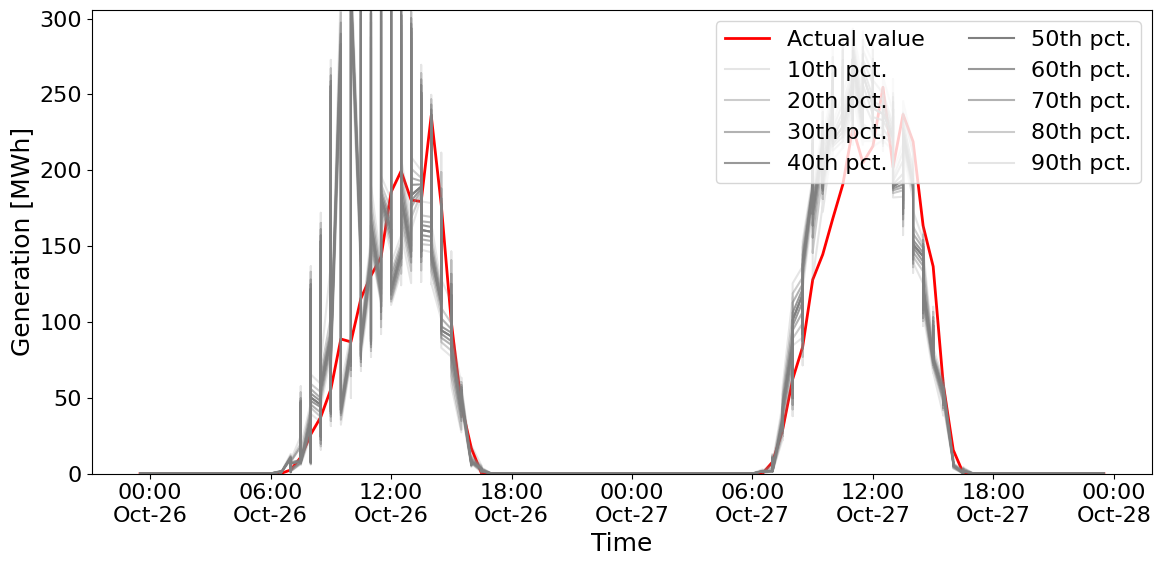

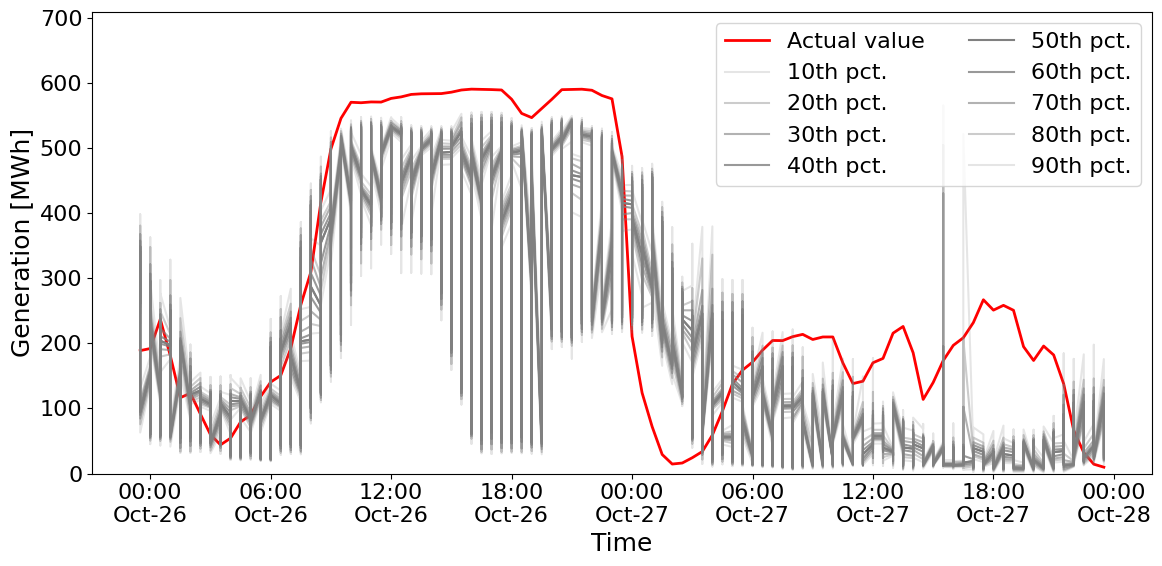

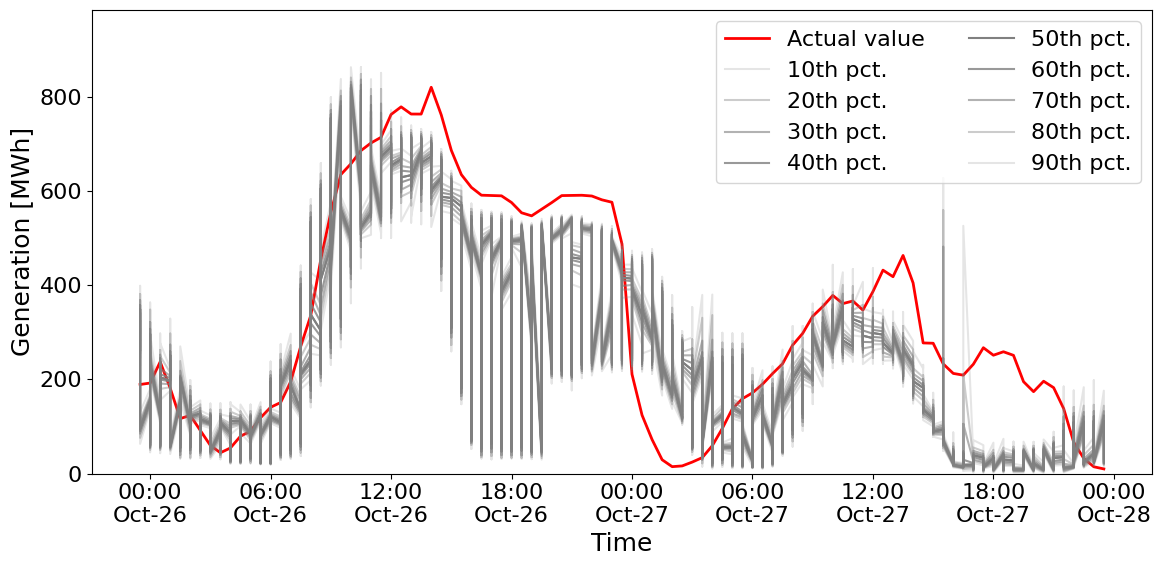

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_last_days(table, y_col):
    df = table.copy()
    df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

    # Filter & sort
    last = df['valid_datetime'].max()
    first = last - pd.Timedelta(days=2)
    last_day = (
        df.loc[(df['valid_datetime'] >= first) & (df['valid_datetime'] <= last)]
          .sort_values('valid_datetime')
    )

    # Font sizes
    plt.rcParams.update({
        'font.size': 18,
        'axes.titlesize': 10,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16
    })

    plt.figure(figsize=(12, 6))

    # True values in red
    plt.plot(
        last_day['valid_datetime'],
        last_day[y_col],
        label='Actual value',
        color='red',
        linewidth=2
    )

    # Quantile lines in gray with symmetric fading
    for q in sorted(QUANTILES):
        alpha = 1 - abs(50 - q) / 50
        plt.plot(
            last_day['valid_datetime'],
            last_day[f'q{q}'],
            color='gray',
            alpha=alpha,
            label=f'{q}th pct.'
        )

    # Highlight median (q50) with full opacity and thicker line
    if 50 in QUANTILES:
        plt.plot(
            last_day['valid_datetime'],
            last_day['q50'],
            color='gray',
            linewidth=1.5,
            alpha=1.0,
        )

    plt.ylim(0, last_day[y_col].max() * 1.2)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%b-%d"))
    plt.xlabel('Time')
    plt.ylabel('Generation [MWh]')
    plt.legend(loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()

# Plot generation
plot_last_days(solar_modelling_table,   "solar_generation_MWh")
plot_last_days(wind_modelling_table,    "wind_generation_MWh")
plot_last_days(combined_modelling_table,"total_generation_MWh")


This is the results on the test set for CatBoost point forecasts.

In [35]:
best_solar_ctb = joblib.load("best_solar_ctb.pkl")
best_wind_ctb  = joblib.load("best_wind_ctb.pkl")

# Perform solar prediction
test_pred_solar_ctb = best_solar_ctb.predict(X_test_solar)

# Drop rows correstponding to Nan in wind test set
test_pred_solar_clean=test_pred_solar_ctb[mask_solar.values]

# Print solar results
print("\n Solar Forecast (CatBoost)")
print("Solar Test MAE:", mean_absolute_error(y_test_solar_clean, test_pred_solar_clean))
print("Solar Test R²:", r2_score(y_test_solar_clean, test_pred_solar_clean))

# Perform solar prediction
test_pred_wind_ctb = best_wind_ctb.predict(X_test_wind)

# Drop rows correstponding to Nan in wind test set
test_pred_wind_clean=test_pred_wind_ctb[mask_wind.values]

# Print wind results
print("\n Wind Forecast (CatBoost)")
print("Wind Test MAE:", mean_absolute_error(y_test_wind_clean, test_pred_wind_clean))
print("Wind Test R²:", r2_score(y_test_wind_clean, test_pred_wind_clean))

# Drop rows corresponding to Nan in thepredictions
pred_solar = test_pred_solar_ctb[mask_combined.values]
pred_wind  = test_pred_wind_ctb[mask_combined.values]

# Define a combined predicitions
pred_total  = pred_solar + pred_wind

# Print combined results
print("\nCombined Forecast (Solar + Wind)")
print("Total Test MAE:",  mean_absolute_error(y_total, pred_total))
print("Total Test R²:",  r2_score(y_total, pred_total))


 Solar Forecast (CatBoost)
Solar Test MAE: 26.623578414337704
Solar Test R²: 0.9265373661389401

 Wind Forecast (CatBoost)
Wind Test MAE: 60.96522428196107
Wind Test R²: 0.8053130759906475

Combined Forecast (Solar + Wind)
Total Test MAE: 74.65094620879586
Total Test R²: 0.841217444564727


This is the results on the test set for Random Forest Regression point forecasts.

In [36]:
#Load models
solar_ctb = joblib.load("solar_ctb.pkl")
wind_ctb  = joblib.load("wind_ctb.pkl")

# Compute quantile forecasts across all tree predictions for each validation sample
solar_quantile_ctb = {}
for q, model in solar_ctb.items():
    solar_quantile_ctb[f"q{q}"] = model.predict(X_test_solar)

# True solar values and each quantile prediction
solar_modelling_table = test_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_test_solar.values
for q in QUANTILES:
    solar_modelling_table[f"q{q}"] = solar_quantile_ctb[f"q{q}"]

print(f"Average Pinball Loss (Solar): {average_pinball_loss(y_test_solar, solar_modelling_table):.4f}")

# Compute quantile forecasts across all tree predictions for each validation sample
wind_quantile_ctb = {}
for q, model in wind_ctb.items():
    wind_quantile_ctb[f"q{q}"] = model.predict(X_test_wind)

# True wind values and each quantile prediction
wind_modelling_table = test_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_test_wind.values
for q in QUANTILES:
    wind_modelling_table[f"q{q}"] = wind_quantile_ctb[f"q{q}"]

print(f"Average Pinball Loss (Wind): {average_pinball_loss(y_test_wind, wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

combined_modelling_table = test_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] +
    wind_modelling_table["wind_generation_MWh"]
)
# Combine solar and wind for each quantile
for q in QUANTILES:
    combined_modelling_table[f"q{q}"] = (
        solar_modelling_table[f"q{q}"] + wind_modelling_table[f"q{q}"]
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")

Average Pinball Loss (Solar): 10.5429
Average Pinball Loss (Wind): 24.5352

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 30.0794


Here we plot the predicitons for CatBoost for the different quantiles compared to the actual value for wind, solar and combined generation.

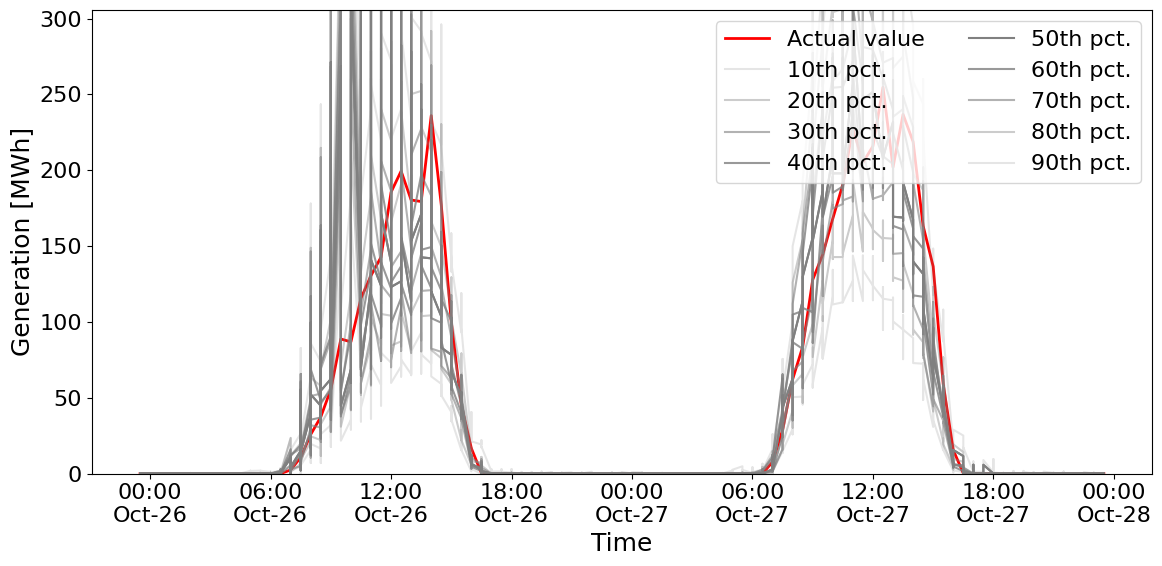

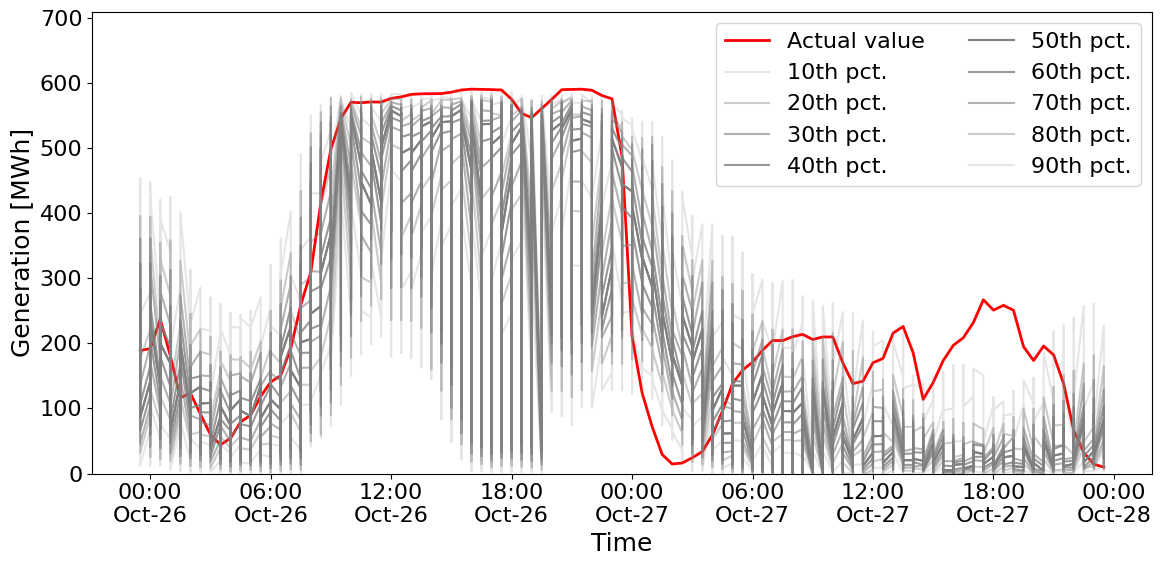

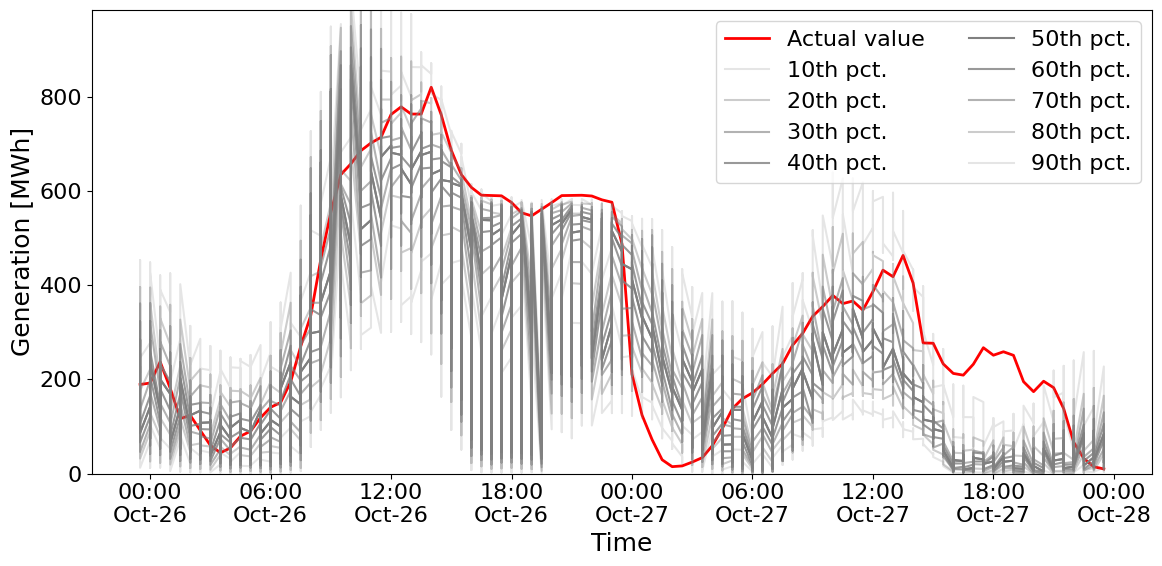

In [37]:
# Plot generation
plot_last_days(solar_modelling_table,   "solar_generation_MWh")
plot_last_days(wind_modelling_table,    "wind_generation_MWh")
plot_last_days(combined_modelling_table,"total_generation_MWh")

This is the results on the test set for LightGBM point forecasts.

In [38]:
#Load models 
best_solar_lgbm = joblib.load("best_solar_lgbm.pkl")
best_wind_lgbm  = joblib.load("best_wind_lgbm.pkl")

# Perform solar prediction
best_solar_lgbm.fit(X_train_solar, y_train_solar)
test_pred_solar_lgbm = best_solar_lgbm.predict(X_test_solar)

# Drop rows correstponding to Nan in wind test set
test_pred_solar_clean=test_pred_solar_lgbm[mask_solar.values]

# Print solar results
print("\n Solar Forecast (LightGBM)")
print("Solar Test MAE:", mean_absolute_error(y_test_solar_clean, test_pred_solar_clean))
print("Solar Test R²:", r2_score(y_test_solar_clean, test_pred_solar_clean))

# Perform solar prediction
best_wind_lgbm.fit(X_train_wind, y_train_wind)
test_pred_wind_lgbm = best_wind_lgbm.predict(X_test_wind)

# Drop rows correstponding to Nan in wind test set
test_pred_wind_clean=test_pred_wind_lgbm[mask_wind.values]

# Print wind results
print("\n Wind Forecast (LightGBM)")
print("Wind Test MAE:", mean_absolute_error(y_test_wind_clean, test_pred_wind_clean))
print("Wind Test R²:", r2_score(y_test_wind_clean, test_pred_wind_clean))

# Drop rows corresponding to Nan in thepredictions
pred_solar = test_pred_solar_lgbm[mask_combined.values]
pred_wind  = test_pred_wind_lgbm[mask_combined.values]

# Define a combined predicitions
pred_total  = pred_solar + pred_wind

# Print combined results
print("\nCombined Forecast (Solar + Wind)")
print("Total Test MAE:",  mean_absolute_error(y_total, pred_total))
print("Total Test R²:",  r2_score(y_total, pred_total))

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations

 Solar Forecast (LightGBM)
Solar Test MAE: 37.604801057940215
Solar Test R²: 0.8686172493331925

 Wind Forecast (LightGBM)
Wind Test MAE: 100.71694154488783
Wind Test R²: 0.587722060983916

Combined Forecast (Solar + Wind)
Total Test MAE: 131.01520019171977
Total Test R²: 0.6041851402318028


This is the results on the test set for LightGBM quantile forecasts.

In [39]:
#Load models 
solar_lgbm = joblib.load("solar_lgbm.pkl")
wind_lgbm  = joblib.load("wind_lgbm.pkl")

# Compute quantile forecasts across all tree predictions for each validation sample
solar_quantile_lgbm = {}
for q, model in solar_lgbm.items():
    solar_quantile_lgbm[f"q{q}"] = model.predict(X_test_solar)

# True wind values and each quantile prediction
solar_modelling_table = test_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_test_solar.values
for q in QUANTILES:
    solar_modelling_table[f"q{q}"] = solar_quantile_lgbm[f"q{q}"]

print(f"Average Pinball Loss (Solar): {average_pinball_loss(y_test_solar, solar_modelling_table):.4f}")

# Compute quantile forecasts across all tree predictions for each validation sample
wind_quantile_lgbm = {}
for q, model in wind_lgbm.items():
    wind_quantile_lgbm[f"q{q}"] = model.predict(X_test_wind)

# True wind values and each quantile prediction
wind_modelling_table = test_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_test_wind.values
for q in QUANTILES:
    wind_modelling_table[f"q{q}"] = wind_quantile_lgbm[f"q{q}"]

print(f"Average Pinball Loss (Wind): {average_pinball_loss(y_test_wind, wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

combined_modelling_table = test_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] +
    wind_modelling_table["wind_generation_MWh"]
)
# Combine solar and wind for each quantile
for q in QUANTILES:
    combined_modelling_table[f"q{q}"] = (
        solar_modelling_table[f"q{q}"] + wind_modelling_table[f"q{q}"]
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")

Average Pinball Loss (Solar): 10.5238
Average Pinball Loss (Wind): 25.1246

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 30.4530


Here we plot the predicitons for LightGBM for the different quantiles compared to the actual value for wind, solar and combined generation.

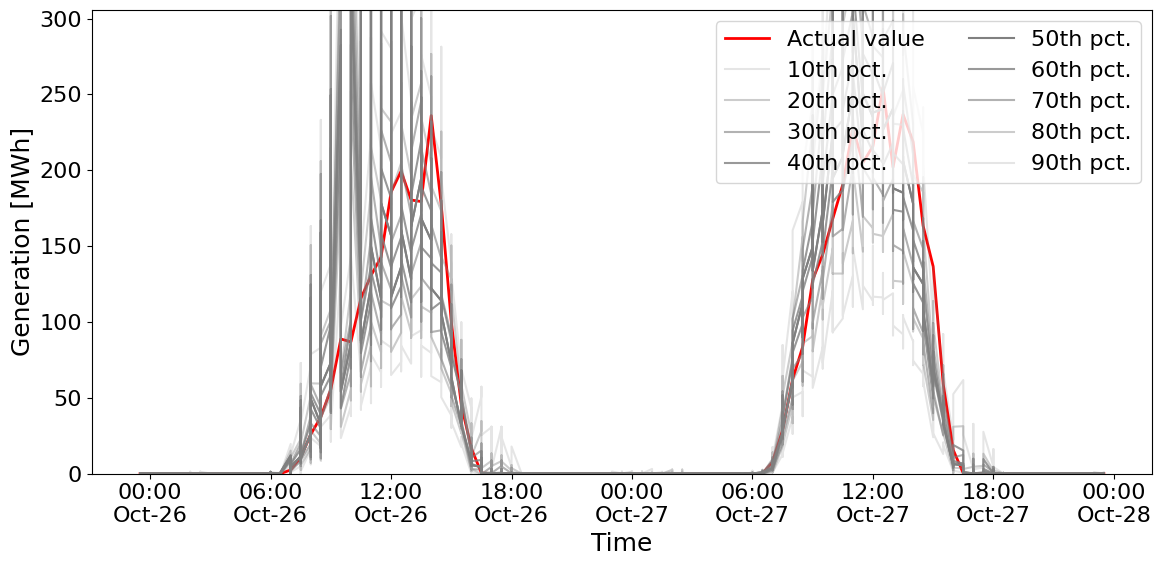

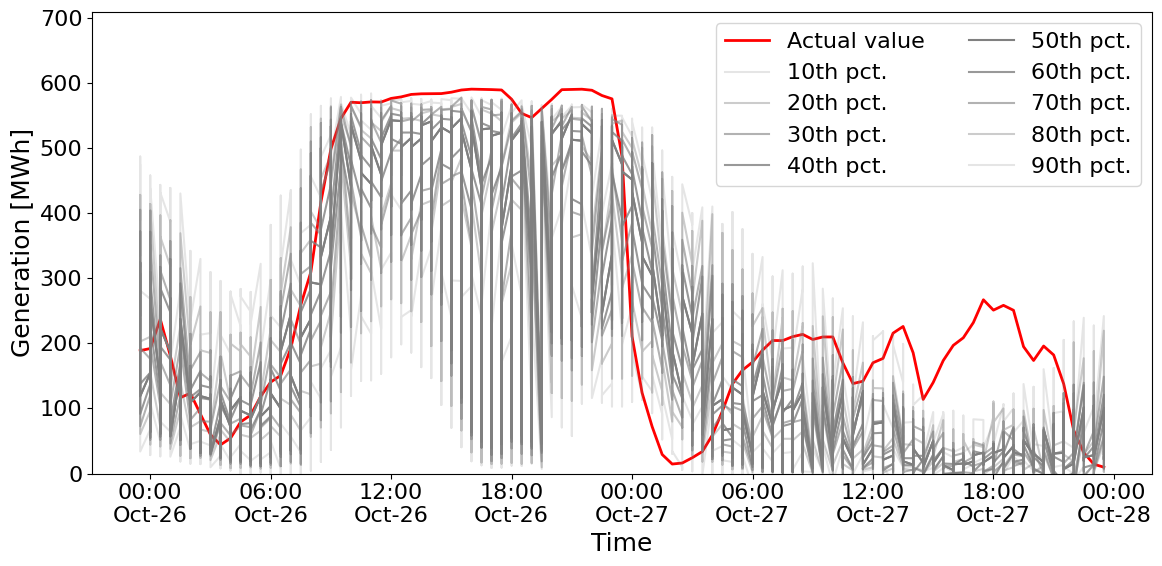

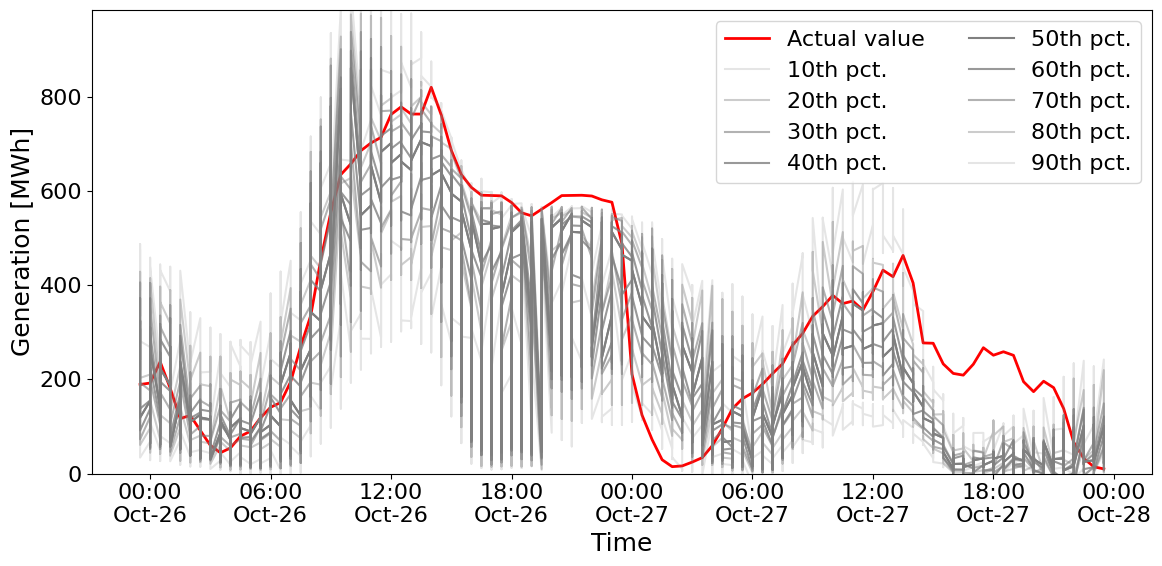

In [40]:
# Plot generation
plot_last_days(solar_modelling_table,   "solar_generation_MWh")
plot_last_days(wind_modelling_table,    "wind_generation_MWh")
plot_last_days(combined_modelling_table,"total_generation_MWh")

This is the results on the test set for ensemble model point forecasts. It utilises the predictions of the other models but keeps the optimal weight based on the earlier training, to not leak any information. 

In [41]:
# Perform solar prediction
X_meta_solar = pd.DataFrame({
    "rf":   test_pred_solar_rfr,
    "cat":  test_pred_solar_ctb,
    "lgbm": test_pred_solar_lgbm
    })
test_pred_solar_meta = stacked_model_point_solar.predict(X_meta_solar)

# Drop rows correstponding to Nan in wind test set
test_pred_solar_clean=test_pred_solar_meta[mask_solar.values]

# Print solar results
print("\n Solar Forecast (Ensemble model)")
print("Solar Test MAE:", mean_absolute_error(y_test_solar_clean, test_pred_solar_clean))
print("Solar Test R²:", r2_score(y_test_solar_clean, test_pred_solar_clean))

# Perform wind prediction
X_meta_wind = pd.DataFrame({
    "rf":   test_pred_wind_rfr,
    "cat":  test_pred_wind_ctb,
    "lgbm": test_pred_wind_lgbm
    })
test_pred_wind_meta = stacked_model_point_wind.predict(X_meta_wind)

# Drop rows correstponding to Nan in wind test set
test_pred_wind_clean=test_pred_wind_meta[mask_wind.values]

# Print wind results
print("\n Wind Forecast (Ensemble model)")
print("Wind Test MAE:", mean_absolute_error(y_test_wind_clean, test_pred_wind_clean))
print("Wind Test R²:", r2_score(y_test_wind_clean, test_pred_wind_clean))

# Drop rows corresponding to Nan in thepredictions
pred_solar = test_pred_solar_meta[mask_combined.values]
pred_wind  = test_pred_wind_meta[mask_combined.values]

# Define a combined predicitions
pred_total  = pred_solar + pred_wind

# Print combined results
print("\nCombined Forecast (Solar + Wind)")
print("Total Test MAE:",  mean_absolute_error(y_total, pred_total))
print("Total Test R²:",  r2_score(y_total, pred_total))


 Solar Forecast (Ensemble model)
Solar Test MAE: 27.45046819107319
Solar Test R²: 0.9278344427713532

 Wind Forecast (Ensemble model)
Wind Test MAE: 63.30026578966801
Wind Test R²: 0.8072475005781451

Combined Forecast (Solar + Wind)
Total Test MAE: 75.8473937782175
Total Test R²: 0.8438932192782513


This is the results on the test set for ensemble model quantile forecasts. It utilises the predictions of the other models but keeps the optimal weight based on the earlier training, to not leak any information. 

In [42]:
# Introduce variable
solar_quantile_meta = {}
for q, model in meta_models_solar.items():
    # Perform solar prediction
    X_meta_solar = pd.DataFrame({
        "rf":   solar_quantile_rfr[f"q{q}"],
        "cat":  solar_quantile_ctb[f"q{q}"],
        "lgbm": solar_quantile_lgbm[f"q{q}"]
    })
    solar_quantile_meta[f"q{q}"] = model.predict(X_meta_solar)

# True solar values and each quantile prediction
solar_modelling_table = test_set.copy()
solar_modelling_table["solar_generation_MWh"] = y_test_solar.values
for q in QUANTILES:
    solar_modelling_table[f"q{q}"] = solar_quantile_meta[f"q{q}"]

print(f"Average Pinball Loss (Solar): {average_pinball_loss(y_test_solar, solar_modelling_table):.4f}")

wind_quantile_meta = {}
for q, model in meta_models_wind.items():
    # Perform solar prediction
    X_meta_wind = pd.DataFrame({
        "rf":   wind_quantile_rfr[f"q{q}"],
        "cat":  wind_quantile_ctb[f"q{q}"],
        "lgbm": wind_quantile_lgbm[f"q{q}"]
    })
    wind_quantile_meta[f"q{q}"] = model.predict(X_meta_wind)

# True wind values and each quantile prediction
wind_modelling_table = test_set.copy()
wind_modelling_table["wind_generation_MWh"] = y_test_wind.values
for q in QUANTILES:
    wind_modelling_table[f"q{q}"] = wind_quantile_meta[f"q{q}"]

print(f"Average Pinball Loss (Wind): {average_pinball_loss(y_test_wind, wind_modelling_table):.4f}")

# Combined Forecast
print("\nCombined Solar + Wind Forecast")

combined_modelling_table = test_set.copy()
combined_modelling_table["total_generation_MWh"] = (
    solar_modelling_table["solar_generation_MWh"] +
    wind_modelling_table["wind_generation_MWh"]
)
# Combine solar and wind for each quantile
for q in QUANTILES:
    combined_modelling_table[f"q{q}"] = (
        solar_modelling_table[f"q{q}"] + wind_modelling_table[f"q{q}"]
    )

print(f"Average Pinball Loss (Combined): {average_pinball_loss(combined_modelling_table['total_generation_MWh'], combined_modelling_table):.4f}")

Average Pinball Loss (Solar): 10.4470
Average Pinball Loss (Wind): 24.0000

Combined Solar + Wind Forecast
Average Pinball Loss (Combined): 29.3939


Here we plot the predicitons for ensemble model for the different quantiles compared to the actual value for wind, solar and combined generation.

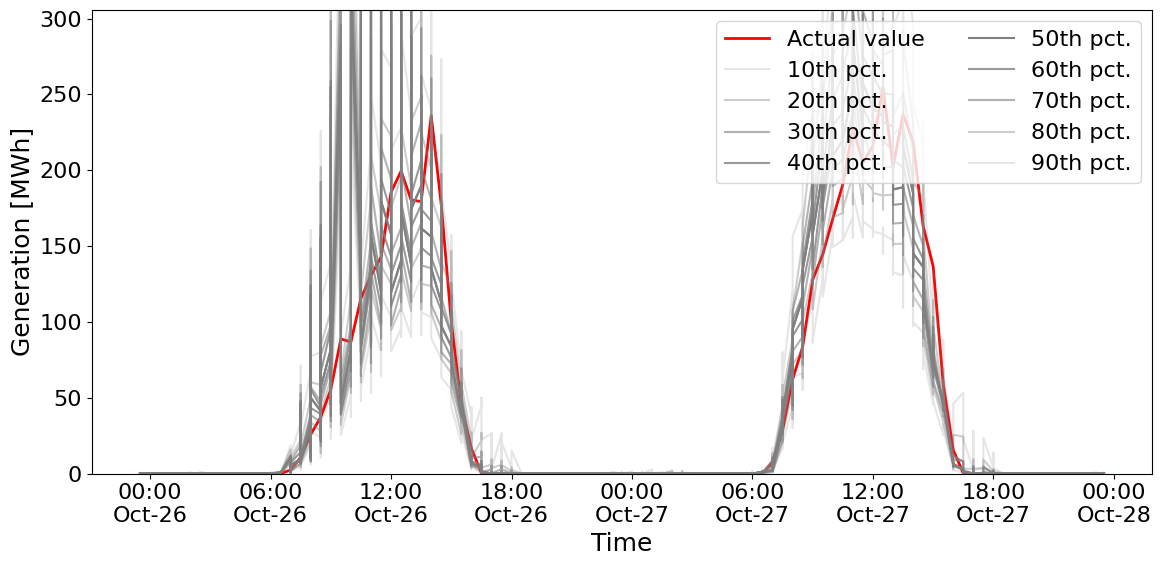

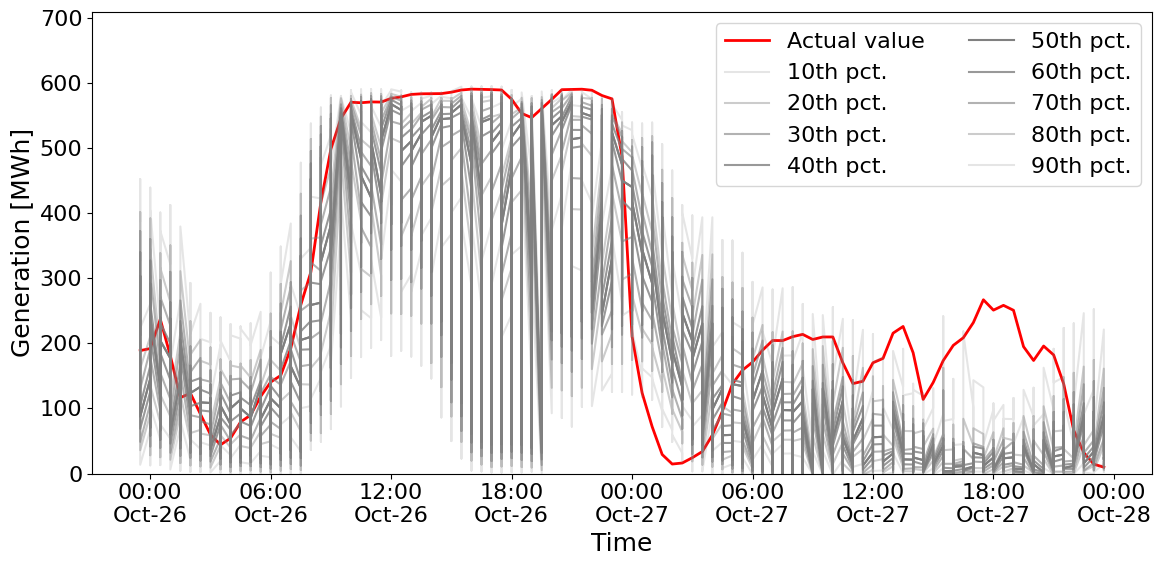

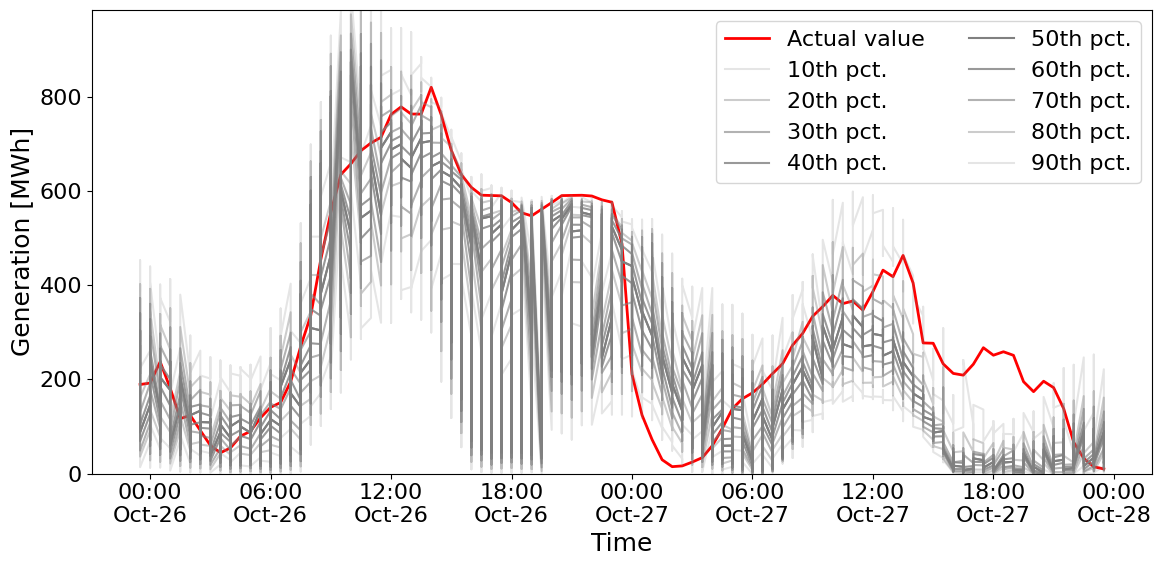

In [43]:
# Plot generation
plot_last_days(solar_modelling_table,   "solar_generation_MWh")
plot_last_days(wind_modelling_table,    "wind_generation_MWh")
plot_last_days(combined_modelling_table,"total_generation_MWh")

Lastly, we include the same naive model as before on the test set to use as a benchmark in the report.

In [44]:
# Sort validation set by time
test_set_sorted = test_set.sort_values("valid_datetime").reset_index(drop=True)

# Create naive predictions (shifted values)
test_set_sorted["Wind_MWh_Pred"] = test_set_sorted["Wind_MWh_credit"].shift(48)
test_set_sorted["Solar_MWh_Pred"] = test_set_sorted["Solar_MWh_credit"].shift(48)

# Drop rows with NaN predictions
test_set_clean = test_set_sorted.dropna(
    subset=["Wind_MWh_credit", "Wind_MWh_Pred",
            "Solar_MWh_credit","Solar_MWh_Pred"]
).reset_index(drop=True)

# Print solar results
print("\nSolar Forecast (Naive)")
print("Solar test MAE:", mean_absolute_error(test_set_clean["Solar_MWh_credit"], test_set_clean["Solar_MWh_Pred"]))
print("Solar test R²:", r2_score(test_set_clean["Solar_MWh_credit"], test_set_clean["Solar_MWh_Pred"]))

# Print wind results
print("\nWind Forecast (Naive)")
print("Wind test MAE:", mean_absolute_error(test_set_clean["Wind_MWh_credit"], test_set_clean["Wind_MWh_Pred"]))
print("Wind test R²:", r2_score(test_set_clean["Wind_MWh_credit"], test_set_clean["Wind_MWh_Pred"]))

# Define a combined observations and predicitions
y_total     = test_set_clean["Solar_MWh_credit"] + test_set_clean["Wind_MWh_credit"]
pred_total  = test_set_clean["Solar_MWh_Pred"] + test_set_clean["Wind_MWh_Pred"]

# Print combined results
print("\nCombined Forecast (Naive)")
print("Total test MAE:",  mean_absolute_error(y_total, pred_total))
print("Total test R²:",  r2_score(y_total, pred_total))

# Quantiles to evaluate
quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Pinball loss for Wind
pinball_loss_wind = pinball_score(test_set_clean["Wind_MWh_credit"], test_set_clean["Wind_MWh_Pred"], quantiles)

# Pinball loss for Solar
pinball_loss_solar = pinball_score(test_set_clean["Solar_MWh_credit"], test_set_clean["Solar_MWh_Pred"], quantiles)

# Combine Wind and Solar predictions
test_set_clean.loc[:, "Combined_MWh_Pred"] = test_set_clean["Wind_MWh_Pred"] + test_set_clean["Solar_MWh_Pred"]
test_set_clean.loc[:, "Combined_MWh_credit"] = test_set_clean["Wind_MWh_credit"] + test_set_clean["Solar_MWh_credit"]

# Pinball loss for Combined Generation
pinball_loss_combined = pinball_score(test_set_clean["Combined_MWh_credit"], test_set_clean["Combined_MWh_Pred"], quantiles)

# Print Results
print(f"Naive Model - Average Pinball loss (Solar): {pinball_loss_solar:.4f}")
print(f"Naive Model - Average Pinball loss (Wind): {pinball_loss_wind:.4f}")
print(f"Naive Model - Average Pinball loss (Combined): {pinball_loss_combined:.4f}")


Solar Forecast (Naive)
Solar test MAE: 109.78033876910824
Solar test R²: 0.2492756593441312

Wind Forecast (Naive)
Wind test MAE: 65.4783635810636
Wind test R²: 0.7654882495214451

Combined Forecast (Naive)
Total test MAE: 146.28120952067724
Total test R²: 0.4593676507166068
Naive Model - Average Pinball loss (Solar): 54.8902
Naive Model - Average Pinball loss (Wind): 32.7392
Naive Model - Average Pinball loss (Combined): 73.1406
